In [1]:
from matplotlib import pyplot as plt

In [14]:
plt.style.use('thomas')

# Defining the ALP spectrum

In [2]:
import numpy as np
import astropy.units as astropy_units
from astromodels.functions.function import (
    Function1D,
    FunctionMeta,
)

class ALPProductionSpectrum(Function1D, metaclass=FunctionMeta):
    r"""
    description :
        ALP production spectrum following Equation 2 from Xiao et al. 2021.
        Includes Bremsstrahlung, Compton, and Primakoff processes.
        Returns dNa/dE in units of keV^-1 s^-1
        
    latex : $ \frac{dN_a}{dE} = \frac{10^{42}}{\rm keV\,s} [C^B g_{13}^2 (\frac{E}{E_0^B})^{\beta^B} e^{-(\beta^B+1)E/E_0^B} + C^C g_{13}^2 (\frac{E}{E_0^C})^{\beta^C} e^{-(\beta^C+1)E/E_0^C} + C^P g_{11}^2 (\frac{E}{E_0^P})^{\beta^P} e^{-(\beta^P+1)E/E_0^P}] $
    
    parameters :
        g_agamma :
            desc : ALP-photon coupling (10^-11 GeV^-1)
            initial value : 1.0
            min : 0
            fix : False
            
        g_ae :
            desc : ALP-electron coupling (10^-13)
            initial value : 1.0
            min : 0
            fix : False
            
        C_B :
            desc : Bremsstrahlung normalization
            initial value : 1.0
            min : 0
            max : 100
            fix : True
            
        E0_B :
            desc : Bremsstrahlung average energy (keV)
            initial value : 100.0
            min : 1
            max : 1000
            fix : True
            
        beta_B :
            desc : Bremsstrahlung spectral index
            initial value : 1.0
            min : 0
            max : 10
            fix : True
            
        C_C :
            desc : Compton normalization
            initial value : 150
            min : 0
            max : 1000
            fix : True
            
        E0_C :
            desc : Compton average energy (keV)
            initial value : 250.0
            min : 1
            max : 1000
            fix : True
            
        beta_C :
            desc : Compton spectral index
            initial value : 3.0
            min : 0
            max : 10
            fix : True
            
        C_P :
            desc : Primakoff normalization
            initial value : 13.0
            min : 0
            max : 100
            fix : True
            
        E0_P :
            desc : Primakoff average energy (keV)
            initial value : 200.0
            min : 1
            max : 1000
            fix : True
            
        beta_P :
            desc : Primakoff spectral index
            initial value : 2.0
            min : 0
            max : 10
            fix : True
            
        BT :
            desc : Transverse magnetic field (μG)
            initial value : 1.4
            min : 0.1
            max : 10
            fix : True
            
        distance :
            desc : Distance (pc)
            initial value : 200.0
            min : 1
            max : 1000
            fix : True
            
        ne :
            desc : Electron density (cm^-3)
            initial value : 0.013
            min : 0.001
            max : 1.0
            fix : True

        ma :
            desc : ALP mass (10^-11 eV)
            initial value : 1.0
            fix : True
    """
    
    def _set_units(self, x_unit, y_unit):
        """Set units for all parameters"""
        self.g_agamma.unit = 1/astropy_units.GeV
        self.g_ae.unit = astropy_units.dimensionless_unscaled
        self.E0_B.unit = astropy_units.keV
        self.E0_C.unit = astropy_units.keV
        self.E0_P.unit = astropy_units.keV
        self.ma.unit = astropy_units.eV
        self.BT.unit = astropy_units.microGauss
        self.distance.unit = astropy_units.pc
        self.ne.unit = astropy_units.dimensionless_unscaled
        
        # Set units for spectral parameters
        for prefix in ['B', 'C', 'P']:
            getattr(self, f'C_{prefix}').unit = astropy_units.dimensionless_unscaled
            getattr(self, f'E0_{prefix}').unit = astropy_units.keV
            getattr(self, f'beta_{prefix}').unit = astropy_units.dimensionless_unscaled
    
    def get_bremsstrahlung(self, E, g_ae=None, C_B=None, E0_B=None, beta_B=None):
        """
        Calculate Bremsstrahlung component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_ae is not None: self.g_ae.value = g_ae
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        rate = 1e42 * self.C_B.value * self.g_ae.value**2 * \
               (E/self.E0_B.value)**self.beta_B.value * \
               np.exp(-(self.beta_B.value + 1)*E/self.E0_B.value)

        return rate * astropy_units.keV**-1 * astropy_units.s**-1
    
    def get_compton(self, E, g_ae=None, C_C=None, E0_C=None, beta_C=None):
        """
        Calculate Compton component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_ae is not None: self.g_ae.value = g_ae
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        rate = 1e42 * self.C_C.value * self.g_ae.value**2 * \
               (E/self.E0_C.value)**self.beta_C.value * \
               np.exp(-(self.beta_C.value + 1)*E/self.E0_C.value)
        return rate * astropy_units.keV**-1 * astropy_units.s**-1
    
    def get_primakoff(self, E, g_agamma=None, C_P=None, E0_P=None, beta_P=None):
        """
        Calculate Primakoff component.
        Uses stored values unless overridden by provided parameters.
        Also updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        rate = 1e42 * self.C_P.value * self.g_agamma.value**2 * \
               (E/self.E0_P.value)**self.beta_P.value * \
               np.exp(-(self.beta_P.value + 1)*E/self.E0_P.value)
        return rate * astropy_units.keV**-1 * astropy_units.s**-1
        
   
    def get_total(self, E, g_agamma=None, g_ae=None,
                  C_B=None, E0_B=None, beta_B=None,
                  C_C=None, E0_C=None, beta_C=None,
                  C_P=None, E0_P=None, beta_P=None):
        """
        Calculate total ALP production rate.
        Uses stored values unless overridden by provided parameters.
        Updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        return (self.get_bremsstrahlung(E) + 
            self.get_compton(E) + 
            self.get_primakoff(E))

    def get_bremsstrahlung_flux(self, x, g_agamma=None, g_ae=None, 
                           C_B=None, E0_B=None, beta_B=None,
                           BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Bremsstrahlung process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Bremsstrahlung ALP production
        dNa_dE = self.get_bremsstrahlung(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux
    
    def get_compton_flux(self, x, g_agamma=None, g_ae=None,
                        C_C=None, E0_C=None, beta_C=None,
                        BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Compton process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Compton ALP production
        dNa_dE = self.get_compton(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux

    def get_primakoff_flux(self, x, g_agamma=None, g_ae=None,
                          C_P=None, E0_P=None, beta_P=None,
                          BT=None, distance=None, ne=None, ma=None):
        """Calculate photon flux from Primakoff process only"""
        # Update stored values if new ones provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
    
        # Get Primakoff ALP production
        dNa_dE = self.get_primakoff(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
         # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux
    
    def evaluate(self, x, g_agamma=None, g_ae=None, 
                C_B=None, E0_B=None, beta_B=None,
                C_C=None, E0_C=None, beta_C=None,
                C_P=None, E0_P=None, beta_P=None,
                BT=None, distance=None, ne=None, ma=None):
        """
        Calculate differential photon flux.
        Uses stored values unless overridden by provided parameters.
        Updates stored values when new ones are provided.
        """
        # Update stored values if new ones are provided
        if g_agamma is not None: self.g_agamma.value = g_agamma
        if g_ae is not None: self.g_ae.value = g_ae
        
        if C_B is not None: self.C_B.value = C_B
        if E0_B is not None: self.E0_B.value = E0_B
        if beta_B is not None: self.beta_B.value = beta_B
        
        if C_C is not None: self.C_C.value = C_C
        if E0_C is not None: self.E0_C.value = E0_C
        if beta_C is not None: self.beta_C.value = beta_C
        
        if C_P is not None: self.C_P.value = C_P
        if E0_P is not None: self.E0_P.value = E0_P
        if beta_P is not None: self.beta_P.value = beta_P
        
        if ma is not None: self.ma.value = ma
        if BT is not None: self.BT.value = BT
        if distance is not None: self.distance.value = distance
        if ne is not None: self.ne.value = ne
        
        # Calculate total rate with updated stored values
        dNa_dE = self.get_total(x)
        
        # Calculate q parameter
        qd = (77 * (self.ma.value * 1e-1)**2 - 0.14 * (self.ne.value/0.013)) * \
            (self.distance.value/197) * (1/x)
        
        # Calculate conversion probability
        Pa = 8.7e-6 * self.g_agamma.value**2 * (self.BT.value/1.0)**2 * \
             (self.distance.value/197)**2 * np.sin(qd)**2 / qd**2
        
        # Convert distance to cm for flux calculation
        distance_cm = (self.distance.value * astropy_units.pc).to(astropy_units.cm)
        
        # Calculate flux with proper units throughout
        flux = dNa_dE * Pa / (4 * np.pi * distance_cm**2)
        
        return flux

14:53:22 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=887910;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=912302;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=873993;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=765954;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=435708;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=285002;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=666952;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=485914;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=607638;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=400231;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=501205;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=332409;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=746531;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=114976;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=188423;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=15124;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=207878;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=87643;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

In [3]:
model = ALPProductionSpectrum()

In [4]:
E = np.logspace(0,3,1000)

In [5]:
g_ae = 1.0
g_agamma = 1.0

# parameters for t_cc = 480yr

In [6]:
C_P = 13.0
E0_P = 180
beta_P = 2.0

In [7]:
C_B = 0.789
E0_B = 134.54
beta_B = 1.02

In [8]:
C_C = 153.2
E0_C = 279.9
beta_C = 3.15

In [9]:
# Get just Bremsstrahlung
brem = model.get_bremsstrahlung(E, g_ae, C_B, E0_B, beta_B)

# Get just Compton
compton = model.get_compton(E, g_ae, C_C, E0_C, beta_C)

# Get just Primakoff
primakoff = model.get_primakoff(E, g_agamma, C_P, E0_P, beta_P)

In [10]:
brem

<Quantity [5.23754782e+39, 5.27406916e+39, 5.31084132e+39, 5.34786598e+39,
           5.38514481e+39, 5.42267950e+39, 5.46047175e+39, 5.49852327e+39,
           5.53683578e+39, 5.57541102e+39, 5.61425072e+39, 5.65335664e+39,
           5.69273054e+39, 5.73237420e+39, 5.77228939e+39, 5.81247793e+39,
           5.85294161e+39, 5.89368225e+39, 5.93470169e+39, 5.97600176e+39,
           6.01758431e+39, 6.05945121e+39, 6.10160433e+39, 6.14404556e+39,
           6.18677679e+39, 6.22979993e+39, 6.27311690e+39, 6.31672964e+39,
           6.36064009e+39, 6.40485019e+39, 6.44936193e+39, 6.49417727e+39,
           6.53929820e+39, 6.58472674e+39, 6.63046489e+39, 6.67651467e+39,
           6.72287813e+39, 6.76955732e+39, 6.81655430e+39, 6.86387114e+39,
           6.91150993e+39, 6.95947278e+39, 7.00776178e+39, 7.05637907e+39,
           7.10532678e+39, 7.15460706e+39, 7.20422208e+39, 7.25417400e+39,
           7.30446502e+39, 7.35509733e+39, 7.40607315e+39, 7.45739470e+39,
           7.50906422e+39

(0.01, 10)

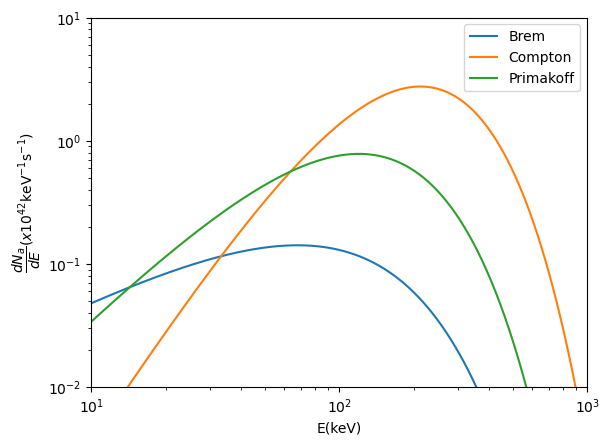

In [11]:
plt.plot(E, brem/1e42, label='Brem')
plt.plot(E, compton/1e42, label='Compton')
plt.plot(E, primakoff/1e42, label='Primakoff')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E(keV)')
plt.ylabel('$\dfrac{dN_a}{dE}(x10^{42} \mathrm{keV^{-1}s^{-1}})$')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [12]:
total = model.get_total(E)

(0.01, 10)

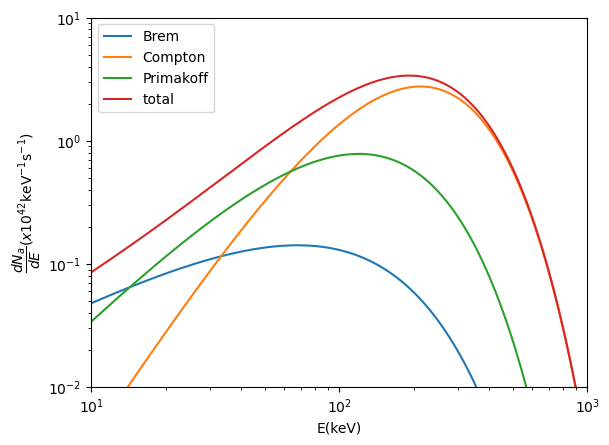

In [13]:
plt.plot(E, brem/1e42, label='Brem')
plt.plot(E, compton/1e42, label='Compton')
plt.plot(E, primakoff/1e42, label='Primakoff')
plt.plot(E, total/1e42, label='total')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E(keV)')
plt.ylabel('$\dfrac{dN_a}{dE}(x10^{42} \mathrm{keV^{-1}s^{-1}})$')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [14]:
total_alt = model.get_total(E,g_agamma=g_agamma, g_ae=g_ae, C_B=C_B, C_C=C_C, C_P=C_P, E0_B=E0_B,E0_C=E0_C,E0_P=E0_P, beta_B=beta_B,beta_C=beta_C,beta_P=beta_P)

(0.01, 10)

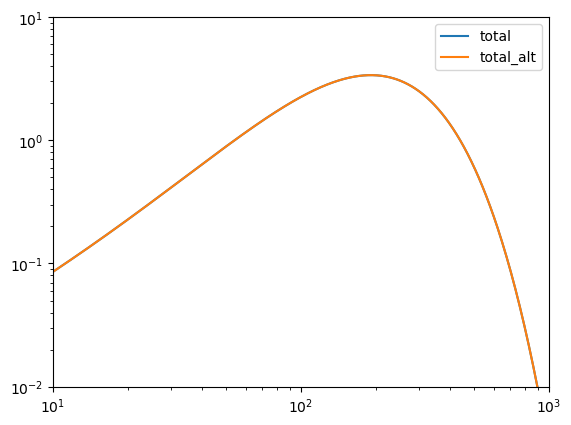

In [15]:
# plt.plot(E, brem/1e42, label='Brem')
# plt.plot(E, compton/1e42, label='Compton')
# plt.plot(E, primakoff/1e42, label='Primakoff')
plt.plot(E, total/1e42, label='total')
plt.plot(E, total_alt/1e42, label='total_alt')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10,1000)
plt.ylim(1e-2,10)

In [16]:
brem_flux = model.get_bremsstrahlung_flux(E,g_agamma=1.5)

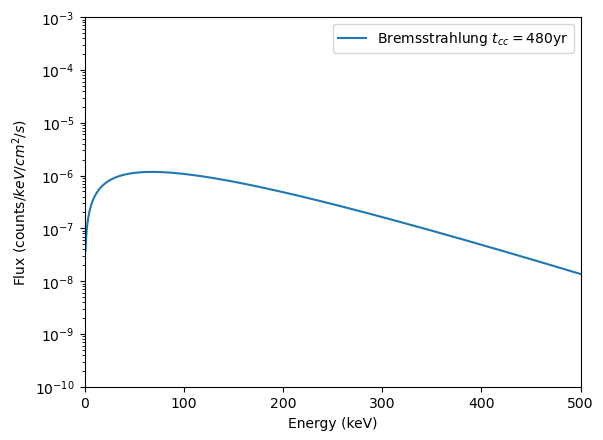

In [17]:
plt.plot(E,brem_flux,label='Bremsstrahlung $t_{cc} = 480 \mathrm{yr}$')
# plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10,1e-3)
plt.xlim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.legend()

In [18]:
comp_flux = model.get_compton_flux(E,g_agamma=1.5)

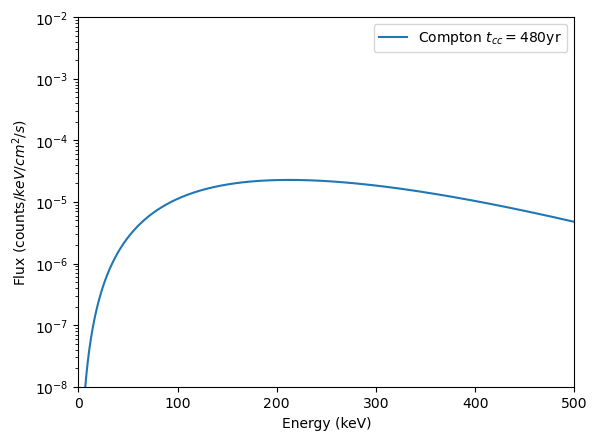

In [19]:
plt.plot(E,comp_flux, label='Compton $t_{cc} = 480 \mathrm{yr}$')
# plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8,1e-2)
plt.xlim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.legend()

# parameters from table 1. Xiao et. al 2022

In [20]:
t_cc = np.array([155000, 23000, 13000, 10000, 6900, 3700, 730, 480, 110, 34, 7.2, 3.6])
C_P = np.array([1.36, 4.0, 5.2, 5.7, 6.5, 7.9, 12, 13, 16, 21, 28, 26])
E0_P = np.array([50, 80, 99, 110, 120, 130, 170, 180, 210, 240, 280, 320])
beta_P = np.array([1.95] + [2.0] * 10 + [1.8])
C_B = np.array([1.3e-3, 2.3e-2, 6.4e-2, 8.9e-2, 0.136, 0.249, 0.827, 0.789, 1.79, 2.82, 3.77, 3.86])
E0_B = np.array([35.26, 56.57, 70.77, 76.65, 85.15, 97.44, 129.17, 134.54, 151.46, 181.74, 207.84, 224.45])
beta_B = np.array([1.16, 1.16, 1.09, 1.08, 1.06, 1.04, 1.02, 1.02, 1.02, 1.00, 0.99, 0.98])
C_C = np.array([1.39, 8.55, 17.39, 22.49, 31.81, 50.62, 138.6, 153.2, 252.7, 447.5, 729.2, 856.4])
E0_C = np.array([77.86, 125.8, 156.9, 169.2, 186.4, 210.4, 269.1, 279.9, 316.8, 363.3, 415.7, 481.2])
beta_C = np.array([3.15, 3.12, 3.09, 3.09, 3.09, 3.11, 3.17, 3.15, 3.17, 3.22, 3.23, 3.11])

In [21]:
line_styles = ['--'] * 4 + ['-'] * 4 + ['-.'] * 4 

# calculating Bremsstrahlung flux for all t_cc. same as Fig. 2(a) Xiao et. al. 2022

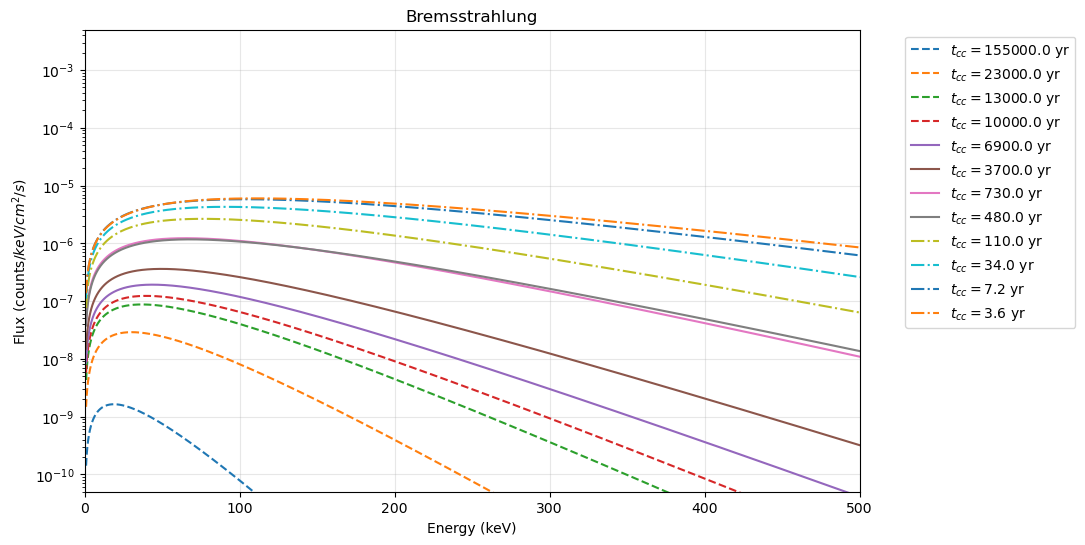

In [22]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(12):
    plt.plot(E, model.get_bremsstrahlung_flux(E, 
                                             g_agamma=1.5, 
                                             C_B=C_B[i], 
                                             E0_B=E0_B[i], 
                                             beta_B=beta_B[i]), 
             linestyle = line_styles[i],
             label=f'$t_{{cc}} = {t_cc[i]}$ yr')

plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.title('Bremsstrahlung')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(5e-11,5e-3)
plt.show()

# calculating Compton flux for all t_cc. same as Fig. 2(b) Xiao et. al. 2022

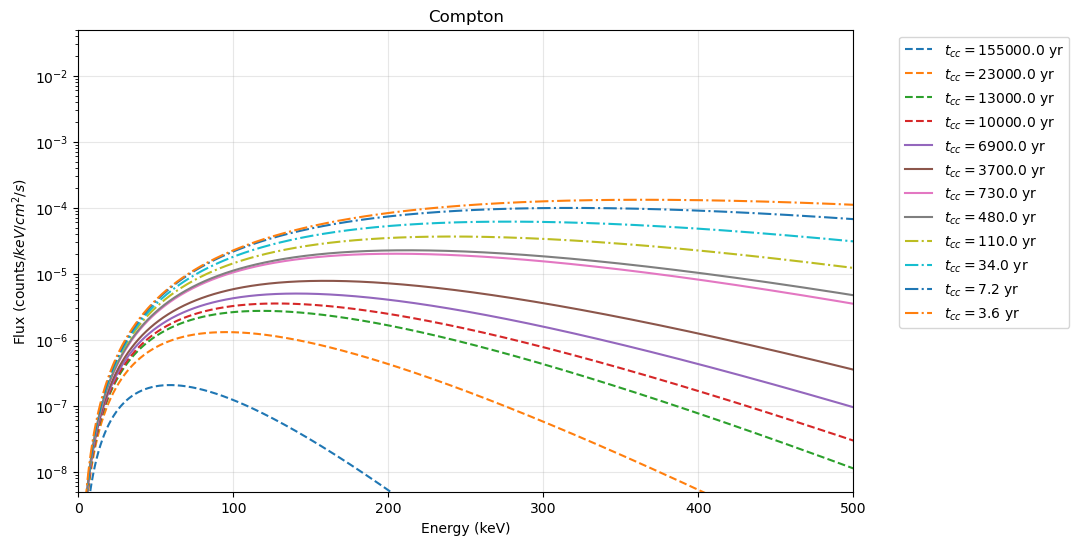

In [23]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(12):
    plt.plot(E, model.get_compton_flux(E, 
                                         g_agamma=1.5, 
                                         C_C=C_C[i], 
                                         E0_C=E0_C[i], 
                                         beta_C=beta_C[i]), 
             linestyle = line_styles[i],
             label=f'$t_{{cc}} = {t_cc[i]}$ yr')

plt.xlabel('Energy (keV)')
plt.ylabel('Flux $(\mathrm{counts} / keV / cm^2 / s)$')
plt.title('Compton')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(5e-9,5e-2)
plt.show()

In [24]:
model.g_agamma = 0.5

In [25]:
g_ae = np.array([0.25, 0.5, 0.75, 1.00, 1.5, 2.0, 2.5, 3.0])

In [26]:
t_cc[4]

6900.0

# total ALP photon flux measured at Earth for g_agamma=0.5e-11 and different g_ae. same as fig. 4(a) Xiao et. al. 2022

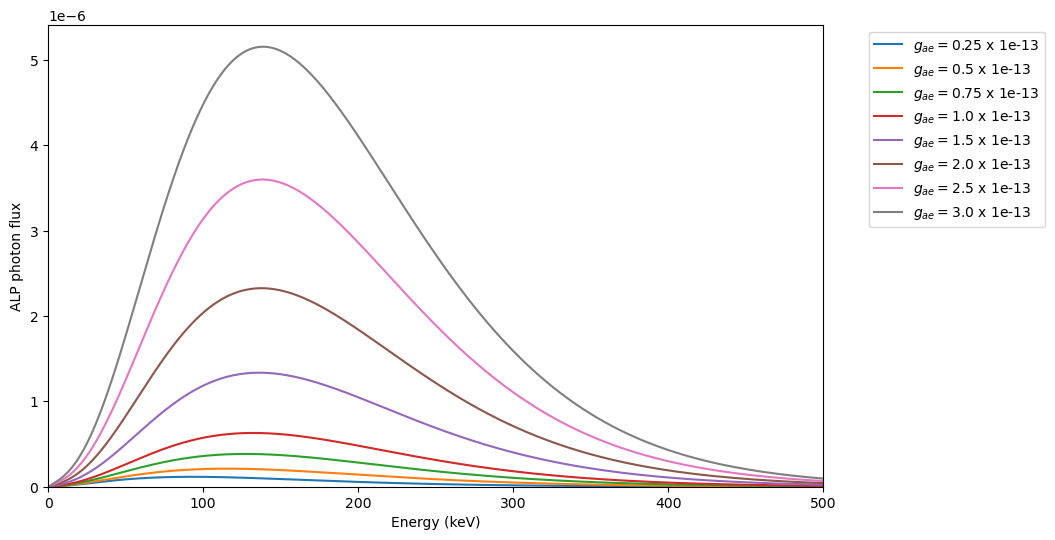

In [27]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(8):
    plt.plot(E, model.evaluate(E, 
                                 g_agamma=0.5, g_ae=g_ae[i], C_B=C_B[4], E0_B=E0_B[4], beta_B=beta_B[4],
                                 C_P=C_P[4], E0_P=E0_P[4], beta_P=beta_P[4],
                                 C_C=C_C[4], 
                                 E0_C=E0_C[4], 
                                 beta_C=beta_C[4]), 
             label=f'$g_{{ae}} = {g_ae[i]}$ x 1e-13')
plt.xlabel('Energy (keV)')
plt.ylabel('ALP photon flux')
plt.xlim(0,500)
plt.ylim(0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# total ALP photon flux measured at Earth for g_agamma=1e-11 and different g_ae. same as fig. 4(b) Xiao et. al. 2022

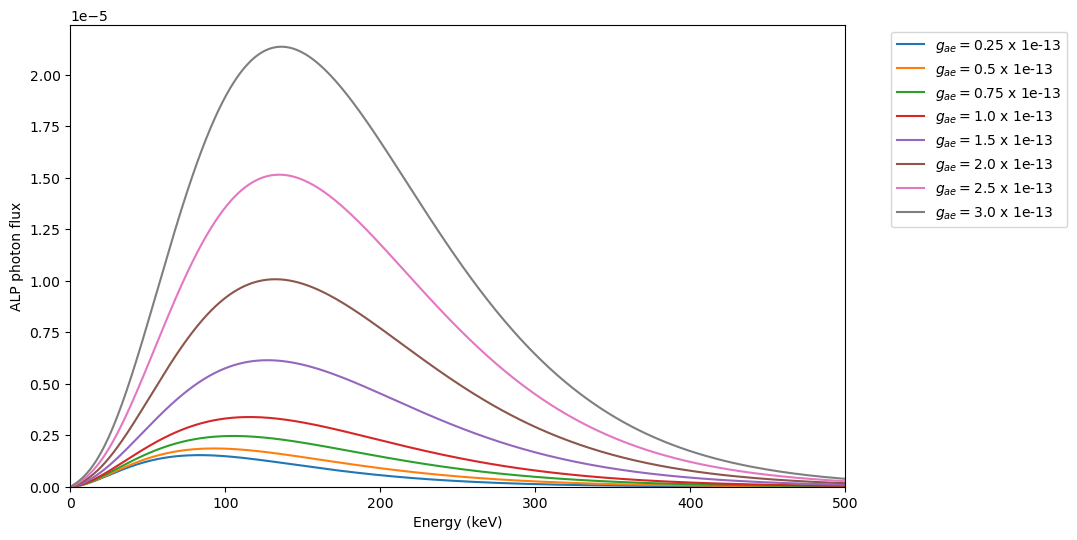

In [28]:
plt.figure(figsize=(10, 6))  # Create a larger figure

for i in range(8):
    plt.plot(E,model.evaluate(E, 
                                 g_agamma=1.0, g_ae=g_ae[i], C_B=C_B[4], E0_B=E0_B[4], beta_B=beta_B[4],
                                 C_P=C_P[4], E0_P=E0_P[4], beta_P=beta_P[4],
                                 C_C=C_C[4], 
                                 E0_C=E0_C[4], 
                                 beta_C=beta_C[4]), 
             label=f'$g_{{ae}} = {g_ae[i]}$ x 1e-13')
plt.xlabel('Energy (keV)')
plt.ylabel('ALP photon flux')
plt.xlim(0,500)
plt.ylim(0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# trying to fit our spectrum from SPI

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as c

from tqdm.autonotebook import tqdm as tqdm
import corner

from threeML import *

/var/folders/fn/dcnsjkb56kbb4bttj1ph1q180000gn/T/ipykernel_34874/924454210.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as tqdm


14:54:32 INFO      Starting 3ML!                                                                     ]8;id=310244;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=376432;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=114697;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=506815;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=853609;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=564101;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=74411;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=789731;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=989447;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=3586;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

14:54:32 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=515631;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=525241;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=808183;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=870297;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=272852;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=955001;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

14:54:34 WARNING   No fermitools installed                                              ]8;id=916644;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=320883;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

In [30]:
import warnings
warnings.simplefilter("ignore")

In [31]:
spec_path = 'fit_Betelgeuse_SE_it01_complete_corrected_bg_energy_lin_05_2keV_per_pointing_source_per_rev/'

In [32]:
fgBet = OGIPLike(name='fgBet',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

14:54:40 WARNING   unable to find SPECTRUM extension: not OGIP PHA!                                      ]8;id=285438;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py\pha.py]8;;\:]8;id=251536;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py#642\642]8;;\

         WARNING   File has no SPECTRUM extension, but found a spectrum in extension SPI.-PHA1-SPE       ]8;id=527147;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py\pha.py]8;;\:]8;id=700962;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/pha.py#652\652]8;;\

         WARNING   Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.                  ]8;id=561832;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=912442;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#274\274]8;;\

         WARNING   FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.    ]8;id=149509;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=359078;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#423\423]8;;\

         WARNING   The response is in an extension called MATRIX, which usually means you also need ]8;id=139817;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=782631;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py#459\459]8;;\
                  an ancillary file (ARF) which you didn't provide. You should refer to the                        
                  documentation  of the instrument and make sure you don't need an ARF.                            

         INFO      Auto-probed noise models:                                                    ]8;id=818537;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=311511;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: gaussian                                                      ]8;id=481043;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=257305;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=67298;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=482611;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

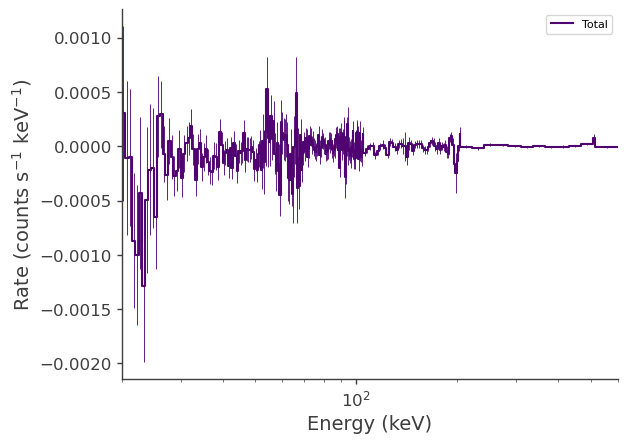

In [33]:
fgBet.view_count_spectrum()
plt.xscale('log')
plt.yscale('linear')

In [34]:
dee = fgBet.energy_boundaries[1]-fgBet.energy_boundaries[0]
ee = 0.5*(fgBet.energy_boundaries[1]+fgBet.energy_boundaries[0])
n_ee = len(ee)

In [35]:
fgBet.set_active_measurements('c0-c233')

14:55:05 INFO      Range c0-c233 translates to channels 0-233                                  ]8;id=603554;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=227102;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

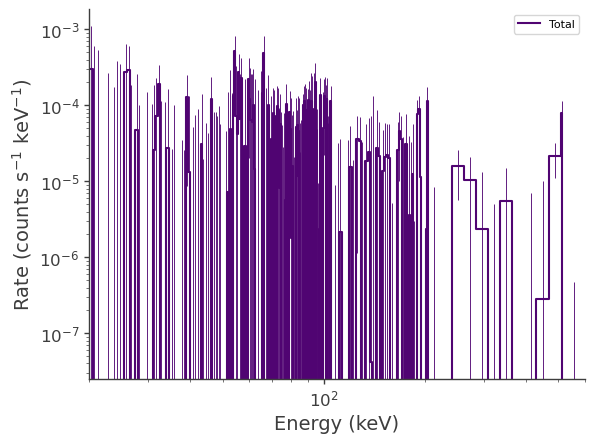

In [36]:
fgBet.view_count_spectrum()
#plt.xscale('linear')
#plt.yscale('linear')
plt.axhline(0)

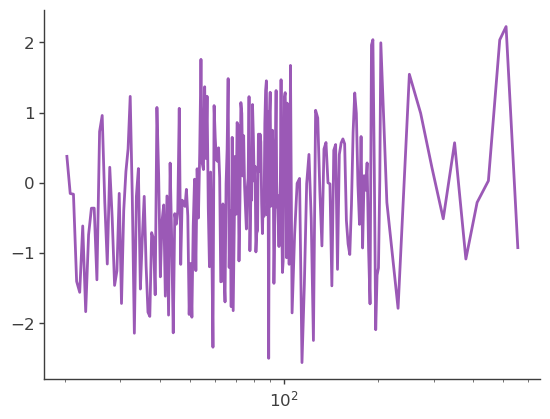

In [37]:
plt.semilogx(ee,fgBet.source_rate/fgBet.source_rate_error)

In [42]:
np.cumsum(fgBet.source_rate*dee),np.sqrt(np.cumsum(fgBet.source_rate_error**2*dee**2))

(array([ 7.57160014e-05,  4.87019843e-05,  2.30754104e-05, -1.94359234e-04,
        -4.44336429e-04, -5.51660303e-04, -8.73042582e-04, -9.96785739e-04,
        -1.05133641e-03, -1.10118581e-03, -1.26472521e-03, -1.19610628e-03,
        -1.12266942e-03, -1.14018504e-03, -1.20679556e-03, -1.19497137e-03,
        -1.21991244e-03, -1.28853585e-03, -1.34594318e-03, -1.35262226e-03,
        -1.42637812e-03, -1.44337494e-03, -1.43691377e-03, -1.41854573e-03,
        -1.37102718e-03, -1.37844081e-03, -1.45588690e-03, -1.46244974e-03,
        -1.45556027e-03, -1.50402918e-03, -1.52930014e-03, -1.53537094e-03,
        -1.57123365e-03, -1.62721897e-03, -1.68541040e-03, -1.70702866e-03,
        -1.73126929e-03, -1.77830720e-03, -1.74599384e-03, -1.74272155e-03,
        -1.78107374e-03, -1.79656537e-03, -1.80517211e-03, -1.85050762e-03,
        -1.85563174e-03, -1.90543439e-03, -1.89777398e-03, -1.91964679e-03,
        -1.97738131e-03, -1.98898542e-03, -2.00462413e-03, -2.01582207e-03,
        -1.9

In [38]:
# 511 keV line
fgBet.source_rate[-2],fgBet.source_rate_error[-2]

(0.00047209038, 0.0002122587)

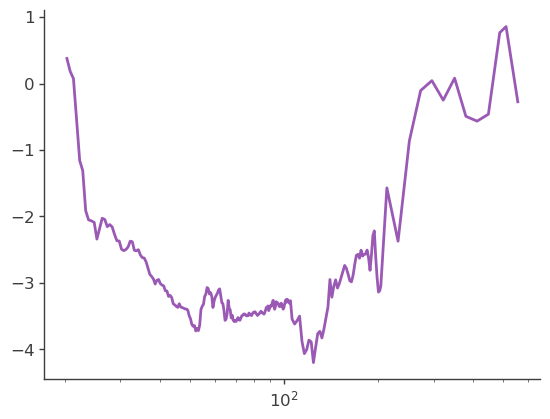

In [39]:
plt.semilogx(ee,np.cumsum(fgBet.source_rate*dee)/np.sqrt(np.cumsum(fgBet.source_rate_error**2*dee**2)))

In [40]:
t_cc

array([1.55e+05, 2.30e+04, 1.30e+04, 1.00e+04, 6.90e+03, 3.70e+03,
       7.30e+02, 4.80e+02, 1.10e+02, 3.40e+01, 7.20e+00, 3.60e+00])

In [78]:
t_idx = 4

fgBet_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_source = PointSource("Betelgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_spectrum)

fgBet_model = Model(fgBet_source)

fgBet_data = DataList(fgBet)

fgBet_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                      value min_value max_value   unit
Betelgeuse...g_agamma   1.0       0.0      None  GeV-1
Betelgeuse...g_ae       3.0       0.0      None       

Fixed parameters (15):
---------------------

                        value min_value max_value unit
Betelgeuse.position.l  199.79       0.0     360.0  deg
Betelgeuse.position.b   -8.96     -90.0      90.0  deg
Betelgeuse...C_B        0.136       0.0     100.0     
Betelgeuse...E0_B       85.15       1.0    1000.0  keV
Betelgeuse...beta_B      1.06       0.0      10.0     
Betelgeuse...C_C        31.81       0.0    1000.0     
Betelgeuse...E0_C       186.4       1.0    1000.0  keV
Betelgeuse...beta_C      3.09       0.0      10.0     
Betelgeuse...C_P          6.5       0.0     100.0     
Betelgeuse...E0_P       120.0       1.0    1000.0  keV
Betelgeuse...beta_P       2.0       0.0      10.0     
Betelgeuse...BT           1.4       0.1      10.0   uG
Betelgeuse...distance   200.0       1.0    1000.0   pc
Betelgeuse...ne         0.013     0.001       1.0     
Betelgeuse...ma           1.0      None      None   eV

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [79]:
g_ae

array([0.25, 0.5 , 0.75, 1.  , 1.5 , 2.  , 2.5 , 3.  ])

In [80]:
fgBet_jl = JointLikelihood(fgBet_model, fgBet_data)

best_fit_parameters_fgBet, likelihood_values_fgBet = fgBet_jl.fit()

12:33:13 INFO      set the minimizer to minuit                                             ]8;id=529727;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=789342;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         WARNING   98.98 percent of samples have been thrown away because they failed the  ]8;id=861287;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=841931;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

result     unit
parameter                                           
Betelgeuse...g_agamma        (0 +/- 9) x 10  1 / GeV
Betelgeuse...g_ae      (0.0 +/- 2.4) x 10^2

Correlation matrix:

1.00 -1.00
-1.00  1.00

Values of -log(likelihood) at the minimum:

-log(likelihood)
fgBet        118.273709
total        118.273709

Values of statistical measures:

statistical measures
AIC            240.599591
BIC            247.449494

In [81]:
"""fgBet_jl.restore_best_fit()
wa = display_spectrum_model_counts(fgBet_jl,step=True,)
wa.axes[0].set_xscale('linear')
wa.axes[0].set_yscale('log')"""

"fgBet_jl.restore_best_fit()\nwa = display_spectrum_model_counts(fgBet_jl,step=True,)\nwa.axes[0].set_xscale('linear')\nwa.axes[0].set_yscale('log')"

In [82]:
# need overlapping sampling regions as otherwise fit gets stuck in some region
ma_lo = np.array([1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9])*1e11
ma_hi = np.array([1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7])*1e11

In [83]:
samples_tot = []
for i in range(len(ma_lo)):
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = ma_lo[i]*10
    # these bounds are important!!!
    # otherwise, the fit goes haywire and doesnt produce the same as with emceee
    # since the parameters are entirely degenerate, we need to constrain them physically
    # I use a range a bit extended from the Xiao paper
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=ma_lo[i],upper_bound=ma_hi[i])
    fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
#     fgBet_bs.set_sampler('emcee')
#     fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=2000, n_walkers=8)
    fgBet_bs.set_sampler('multinest')
    fgBet_bs.sampler.setup(n_live_points=1000)
    result = fgBet_bs.sample()
    samples_tot.append(fgBet_bs.raw_samples)

12:36:51 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=589308;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=801873;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

12:36:51 INFO      sampler set to multinest                                                ]8;id=582996;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=473164;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
 ln(ev)=  -119.47202040986501      +/-   3.3535455201433639E-002
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:         4300
 Sampling finished. Exiting MultiNest


12:36:56 INFO      fit restored to maximum of posterior                                         ]8;id=245789;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=494681;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=571925;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=571988;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                              (0.15 +0.04 +4) x 10^-1   
Betelgeuse...g_ae                                      0.0001 +0.0005 +1.2   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.16 +0.05 +5) x 10^-3   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet       -96.318652
total       -96.318652

Values of statistical measures:

statistical measures
AIC               198.742107
BIC               208.990419
DIC               200.510463
PDIC              -10.692047
log(Z)            -51.886039

12:36:56 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=875394;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=816483;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=364178;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=287401;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -119.47255414729557      +/-   3.3512478967202775E-002
 Total Likelihood Evaluations:         4328
 Sampling finished. Exiting MultiNest



12:37:00 INFO      fit restored to maximum of posterior                                         ]8;id=708108;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=579551;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=888202;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=496118;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                              (0.13 +0.07 +4) x 10^-1   
Betelgeuse...g_ae                                      0.0001 +0.0005 +1.4   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.12 +0.09 +5) x 10^-2   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet       -98.275765
total       -98.275765

Values of statistical measures:

statistical measures
AIC               202.656333
BIC               212.904644
DIC               204.704291
PDIC              -11.238411
log(Z)            -51.886271

12:37:01 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=301625;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=866770;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

12:37:01 INFO      sampler set to multinest                                                ]8;id=454888;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=732690;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -119.41057682187670      +/-   3.2691492080083477E-002
 Total Likelihood Evaluations:         4177
 Sampling finished. Exiting MultiNest



12:37:05 INFO      fit restored to maximum of posterior                                         ]8;id=521739;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=523434;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=821764;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=638862;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                      
Betelgeuse...g_agamma                              (0.210 -0.031 +4) x 10^-1   
Betelgeuse...g_ae                                        0.0001 +0.0005 +1.6   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.170 +0.034 +5) x 10^-1   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet      -101.230647
total      -101.230647

Values of statistical measures:

statistical measures
AIC               208.566097
BIC               218.814409
DIC               209.055658
PDIC              -11.159704
log(Z)            -51.859355

12:37:05 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=945911;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=523409;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=359627;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=110690;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -119.43966955199167      +/-   3.3091006086755387E-002
 Total Likelihood Evaluations:         4285
 Sampling finished. Exiting MultiNest



12:37:10 INFO      fit restored to maximum of posterior                                         ]8;id=80818;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=675059;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=41659;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=198244;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                              (0.15 +0.04 +4) x 10^-1   
Betelgeuse...g_ae                                      0.0001 +0.0004 +1.4   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma            0.15 +0.08 +5   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet      -103.282922
total      -103.282922

Values of statistical measures:

statistical measures
AIC               212.670648
BIC               222.918959
DIC               213.754523
PDIC              -11.136773
log(Z)            -51.871989

12:37:10 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=643140;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=695935;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=390687;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=766571;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -119.23540021314348      +/-   3.0132182966912127E-002
 Total Likelihood Evaluations:         4601
 Sampling finished. Exiting MultiNest



12:37:15 INFO      fit restored to maximum of posterior                                         ]8;id=705828;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=403425;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=344750;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=743433;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                      
Betelgeuse...g_agamma                              (0.206 -0.021 +6) x 10^-1   
Betelgeuse...g_ae                                        0.0001 +0.0006 +3.2   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       (0.17 +0.05 +5) x 10   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet      -105.903398
total      -105.903398

Values of statistical measures:

statistical measures
AIC               217.911599
BIC               228.159911
DIC               215.352932
PDIC              -15.777988
log(Z)            -51.783276

12:37:15 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=37136;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=359499;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=4507;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=37107;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -118.76149967303722      +/-   2.1285467443519401E-002
 Total Likelihood Evaluations:         3832
 Sampling finished. Exiting MultiNest



12:37:19 INFO      fit restored to maximum of posterior                                         ]8;id=361968;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=217775;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=441145;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=881966;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                   
Betelgeuse...g_agamma                                     0.012 +0.014 +5   
Betelgeuse...g_ae                                      (0.0 +9 +2.5) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.20 +0.18 +6) x 10^2   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet      -107.752885
total      -107.752885

Values of statistical measures:

statistical measures
AIC               221.610574
BIC               231.858886
DIC               220.862753
PDIC              -19.899158
log(Z)            -51.577464

12:37:19 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=957054;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=749220;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=693978;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=972598;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -118.41933514739321      +/-   1.1353683372505082E-002
 Total Likelihood Evaluations:         3155
 Sampling finished. Exiting MultiNest



12:37:23 INFO      fit restored to maximum of posterior                                         ]8;id=73080;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=216080;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=176351;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=51865;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                       
Betelgeuse...g_agamma                              (0.0014 +0.0020 +1.3) x 10   
Betelgeuse...g_ae                                      (0.0 +1.5 +1.9) x 10^2   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma      (0.16 +0.13 +6) x 10^3   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet      -110.304496
total      -110.304496

Values of statistical measures:

statistical measures
AIC               226.713796
BIC               236.962108
DIC               230.175551
PDIC              -18.899906
log(Z)            -51.428864

In [92]:
n_samples = [np.array(samples_tot).ravel()[i].shape[0] for i in range(7)]
n_samples_sum = np.sum(n_samples)
n_samples_cumsum = np.cumsum(n_samples)
n_samples_sum

14291

In [93]:
n_samples_cumsum = np.concatenate([np.array([0]),n_samples_cumsum])
n_samples_cumsum

array([    0,  1962,  3962,  5919,  7906, 10111, 12260, 14291])

In [94]:
np.array(samples_tot)[0].shape

(1962, 3)

In [108]:
samples_tot[0].shape

(1962, 3)

In [97]:
n_samples_cumsum[0],n_samples_cumsum[0+1]

(0, 1962)

In [109]:
what = np.zeros((n_samples_sum,3))
for i in range(7):
    what[n_samples_cumsum[i]:n_samples_cumsum[i+1],:] = samples_tot[i]

In [110]:
what.shape

(14291, 3)

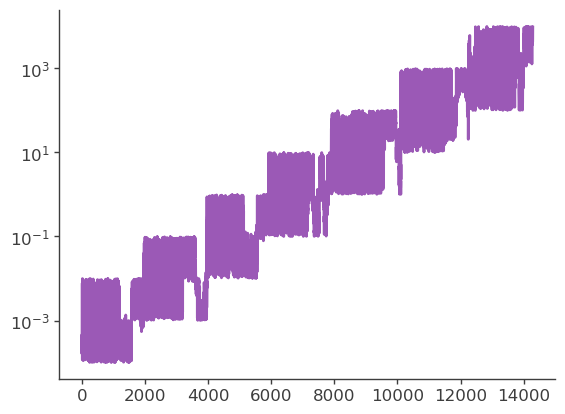

In [117]:
plt.plot(what[:,2])
plt.yscale('log')

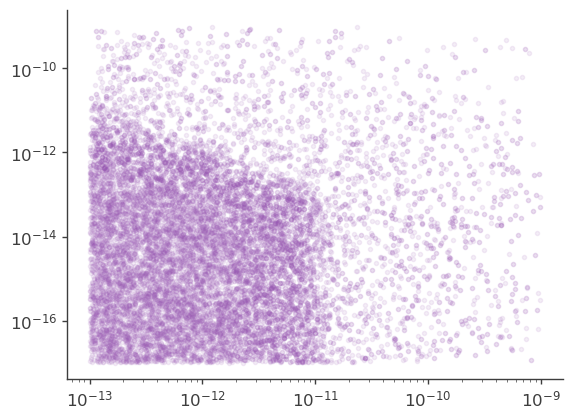

In [118]:
plt.plot(what[:,0]*1e-11,what[:,1]*1e-13,'.',alpha=0.1)
plt.yscale('log')
plt.xscale('log')

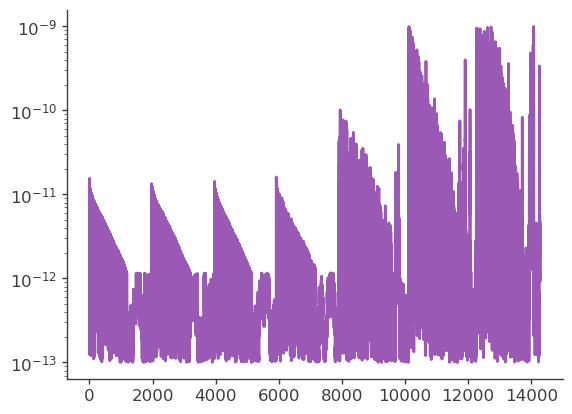

In [119]:
plt.plot(what[:,0]*1e-11)
plt.yscale('log')

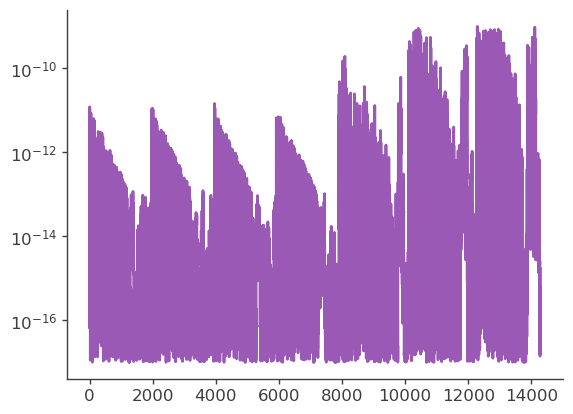

In [120]:
plt.plot(what[:,1]*1e-13)
plt.yscale('log')

In [121]:
"""# lowest masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 0.01
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-3,upper_bound=1e-1)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples_lo_lo = fgBet_bs.raw_samples

# medium masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 1
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples_lo = fgBet_bs.raw_samples

# higher masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 100
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e1,upper_bound=1e3)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples = fgBet_bs.raw_samples"""

"# lowest masses:\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 0.01\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-3,upper_bound=1e-1)\nfgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)\nfgBet_bs.set_sampler('emcee')\nfgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)\nresult = fgBet_bs.sample()\nsamples_lo_lo = fgBet_bs.raw_samples\n\n# medium masses:\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 1\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior

In [123]:
"""plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)
plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)
plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)

plt.ylim(1e-25,1e-20)"""

"plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\nplt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\nplt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\n\nplt.ylim(1e-25,1e-20)"

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$  [GeV$^{-1}$]')

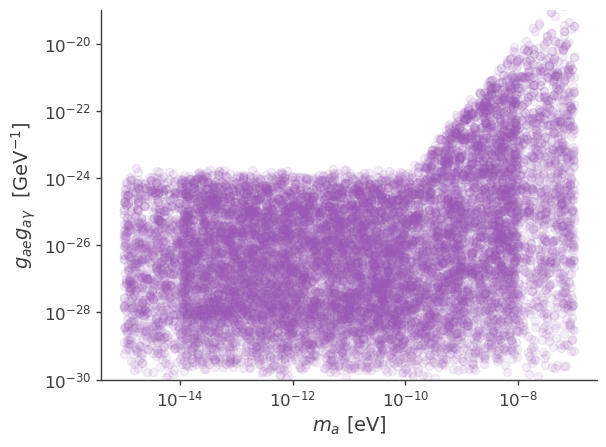

In [125]:
plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)

plt.ylim(1e-30,1e-19)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$  [GeV$^{-1}$]')

In [126]:
n_ma_bins = 30
ma_bin_edges = np.geomspace(1e-15,1e-7,n_ma_bins+1)
ma_bin_min = ma_bin_edges[0:-1]
ma_bin_max = ma_bin_edges[1:]
ma_bin_cen = 0.5*(ma_bin_max+ma_bin_min)

In [127]:
gage_ul = np.zeros(n_ma_bins)
for i in range(n_ma_bins):
    try:
        idx = np.where((what[:,2]*1e-11 >= ma_bin_min[i]) & (what[:,2]*1e-11 <= ma_bin_max[i]))[0]
        #print(idx)
        gage_tmp = np.percentile(what[idx,0]*what[idx,1],95)
        gage_ul[i] = gage_tmp*1e-24
    except:
        print('{0} not working'.format(i))

In [128]:
from scipy.ndimage import gaussian_filter1d as smooth

In [129]:
# showing everything for own checks

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

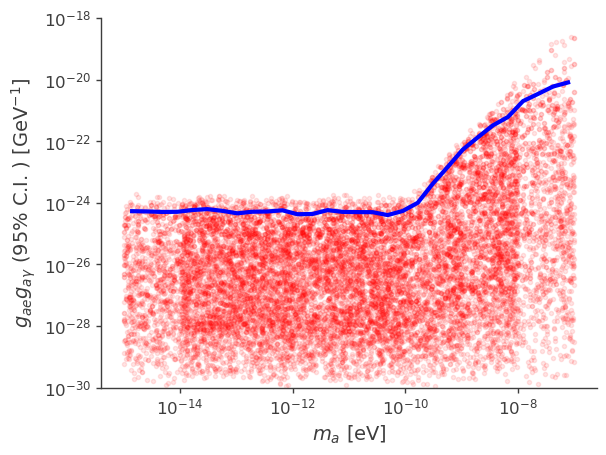

In [130]:
# plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')


plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='.',linestyle='',alpha=0.1,color='red')

plt.plot(ma_bin_cen,smooth(gage_ul,0.5,mode='nearest'),color='blue',linewidth=3)


plt.ylim(1e-30,1e-18)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

In [131]:
# what we would show in a paper:

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

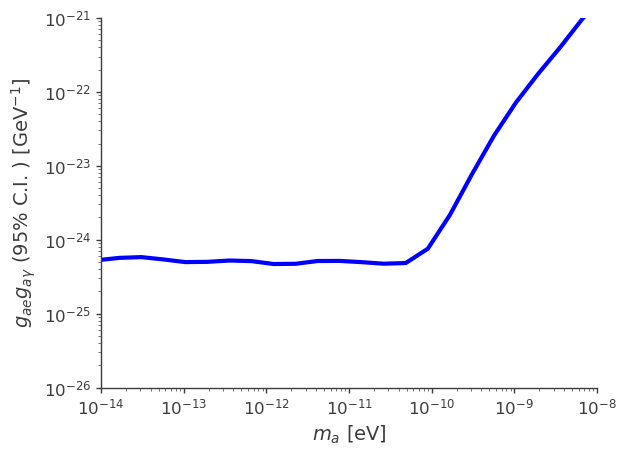

In [132]:
#plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='.',linestyle='',alpha=0.1,color='red')

plt.loglog(ma_bin_cen,smooth(gage_ul,1,mode='nearest'),color='blue',linewidth=3)


plt.ylim(1e-26,1e-21)
plt.xlim(1e-14,1e-8)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

In [133]:
# neat

In [134]:
# now can repeat for other times until explosion ...
# more samples
# whatever

In [135]:
idx = np.where((what[:,2]*1e-11 >= 0.99e-11) & (what[:,2]*1e-11 <= 1.01e-11))[0]
        #print(idx)
idx2 = np.where((what[:,2]*1e-11 >= 0.99e-10) & (what[:,2]*1e-11 <= 1.01e-10))[0]
        #print(idx)
idx3 = np.where((what[:,2]*1e-11 >= 0.99e-9) & (what[:,2]*1e-11 <= 1.01e-9))[0]
        #print(idx)
idx4 = np.where((what[:,2]*1e-11 >= 0.99e-12) & (what[:,2]*1e-11 <= 1.01e-12))[0]
        #print(idx)
idx5 = np.where((what[:,2]*1e-11 >= 0.99e-13) & (what[:,2]*1e-11 <= 1.01e-13))[0]
        #print(idx)

In [136]:
idx35 = np.where(what[:,2]*1e-11 < 3.5e-11)[0]

In [137]:
idx.shape,idx2.shape,idx3.shape,idx4.shape,idx5.shape

((14,), (22,), (29,), (17,), (16,))

In [73]:
# what[idx,0]*1e-11

Text(0, 0.5, '$g_{ae}$')

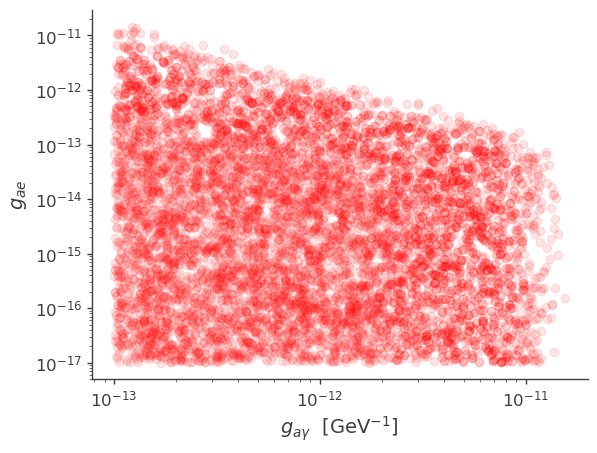

In [142]:
plt.loglog(what[idx35,0]*1e-11,what[idx35,1]*1e-13,'ro',alpha=0.1)
# plt.loglog(what[idx2,0]*1e-11,what[idx2,1]*1e-13,'bo',alpha=0.1)
# plt.loglog(what[idx3,0]*1e-11,what[idx3,1]*1e-13,'go',alpha=0.1)
# plt.loglog(what[idx4,0]*1e-11,what[idx4,1]*1e-13,'ko',alpha=0.1)
# plt.loglog(what[idx5,0]*1e-11,what[idx5,1]*1e-13,'mo',alpha=0.1)
plt.xlabel(r'$g_{a\gamma}$  [GeV$^{-1}$]')
plt.ylabel(r'$g_{ae}$')

In [139]:
n_gagamma_bins = 30
gagamma_bin_edges = np.geomspace(1e-13,1e-10,n_gagamma_bins+1)
gagamma_bin_min = gagamma_bin_edges[0:-1]
gagamma_bin_gagammax = gagamma_bin_edges[1:]
gagamma_bin_cen = 0.5*(gagamma_bin_gagammax+gagamma_bin_min)

In [140]:
gae_ul = np.zeros(n_gagamma_bins)
for i in range(n_gagamma_bins):
    try:
        idx = np.where((what[:,0]*1e-11 >= gagamma_bin_min[i]) & (what[:,0]*1e-11 <= gagamma_bin_gagammax[i]) & (what[:,2]*1e-11 < 3.5e-11))[0]
        #print(idx)
        gae_tmp = np.percentile(what[idx,1],95)
        gae_ul[i] = gae_tmp*1e-13
    except:
        print('{0} not working'.format(i))

22 not working
23 not working
24 not working
25 not working
26 not working
27 not working
28 not working
29 not working


Text(0, 0.5, '$g_{ae}$')

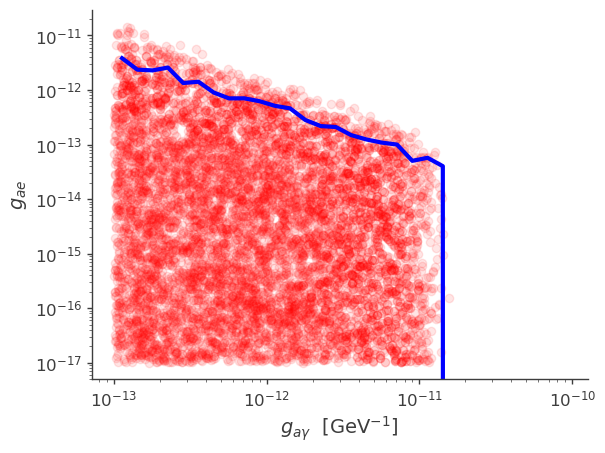

In [143]:
plt.loglog(what[idx35,0]*1e-11,what[idx35,1]*1e-13,'ro',alpha=0.1)
plt.plot(gagamma_bin_cen,smooth(gae_ul,0.05,mode='nearest'),color='blue',linewidth=3)
plt.xlabel(r'$g_{a\gamma}$  [GeV$^{-1}$]')
plt.ylabel(r'$g_{ae}$')

In [87]:
spec_path = 'fit_Betelgeuse_SE_it01_complete_corrected_bg_energy_lin_05_2keV_per_pointing_source_per_rev/'

In [88]:
fgBet_1 = OGIPLike(name='fgBet_1',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

[WARNING ] unable to find SPECTRUM extension: not OGIP PHA!
[WARNING ] File has no SPECTRUM extension, but found a spectrum in extension SPI.-PHA1-SPE
[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None


In [89]:
fgBet_2 = OGIPLike(name='fgBet_2',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

[WARNING ] unable to find SPECTRUM extension: not OGIP PHA!
[WARNING ] File has no SPECTRUM extension, but found a spectrum in extension SPI.-PHA1-SPE
[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None


In [90]:
t_idx = 4

fgBet_2_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_2_spectrum.ma.free = True
fgBet_2_spectrum.ma = 1

fgBet_2_spectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
fgBet_2_spectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
fgBet_2_spectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)

fgBet_2_source = PointSource("Bet_2elgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_2_spectrum)

# fgBet_2_model = Model(fgBet_2_source)

# fgBet_2_data = DataList(fgBet_2)

# fgBet_2_model.display(complete=True)

In [91]:
t_idx = 4

fgBet_1_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_1_spectrum.ma.free = True
fgBet_1_spectrum.ma = 1

fgBet_1_spectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
fgBet_1_spectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
fgBet_1_spectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)

fgBet_1_source = PointSource("Bet_1elgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_1_spectrum)

# fgBet_1_model = Model(fgBet_1_source)

# fgBet_1_data = DataList(fgBet_1)

# fgBet_1_model.display(complete=True)

In [92]:
model_combined = Model(fgBet_1_source,fgBet_2_source)

In [93]:
model_combined.display(complete=True)

Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                        value min_value max_value   unit
Bet_1elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_1elgeuse...g_ae       3.0       0.0      None       
Bet_1elgeuse...ma         1.0      None      None     eV
Bet_2elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_2elgeuse...g_ae       3.0       0.0      None       
Bet_2elgeuse...ma         1.0      None      None     eV

Fixed parameters (28):
---------------------

                          value min_value max_value unit
Bet_1elgeuse.position.l  199.79       0.0     360.0  deg
Bet_1elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_1elgeuse...C_B        0.136       0.0     100.0     
Bet_1elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_1elgeuse...beta_B      1.06       0.0      10.0     
Bet_1elgeuse...C_C        31.81       0.0    1000.0     
Bet_1elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_1elgeuse...beta_C      3.09       0.0      10.0     
Bet_1elgeuse...C_P          6.5       0.0     100.0     
Bet_1elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_1elgeuse...beta_P       2.0       0.0      10.0     
Bet_1elgeuse...BT           1.4       0.1      10.0   uG
Bet_1elgeuse...distance   200.0       1.0    1000.0   pc
Bet_1elgeuse...ne         0.013     0.001       1.0     
Bet_2elgeuse.position.l  199.79       0.0     360.0  deg
Bet_2elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_2elgeuse...C_B        0.136       0.0     100.0     
Bet_2elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_2elgeuse...beta_B      1.06       0.0      10.0     
Bet_2elgeuse...C_C        31.81       0.0    1000.0     
Bet_2elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_2elgeuse...beta_C      3.09       0.0      10.0     
Bet_2elgeuse...C_P          6.5       0.0     100.0     
Bet_2elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_2elgeuse...beta_P       2.0       0.0      10.0     
Bet_2elgeuse...BT           1.4       0.1      10.0   uG
Bet_2elgeuse...distance   200.0       1.0    1000.0   pc
Bet_2elgeuse...ne         0.013     0.001       1.0     

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

In [94]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.ma,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.ma
)

In [95]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_ae,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.g_ae
)

In [96]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma
)

In [97]:
model_combined.display(complete=True)

Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                        value min_value max_value   unit
Bet_2elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_2elgeuse...g_ae       3.0       0.0      None       
Bet_2elgeuse...ma         1.0      None      None     eV

Fixed parameters (34):
---------------------

                          value min_value max_value unit
Bet_1elgeuse.position.l  199.79       0.0     360.0  deg
Bet_1elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_1elgeuse...a            0.0      None      None   eV
Bet_1elgeuse...b            1.0      None      None     
Bet_1elgeuse...C_B        0.136       0.0     100.0     
Bet_1elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_1elgeuse...beta_B      1.06       0.0      10.0     
Bet_1elgeuse...C_C        31.81       0.0    1000.0     
Bet_1elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_1elgeuse...beta_C      3.09       0.0      10.0     
Bet_1elgeuse...C_P          6.5       0.0     100.0     
Bet_1elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_1elgeuse...beta_P       2.0       0.0      10.0     
Bet_1elgeuse...BT           1.4       0.1      10.0   uG
Bet_1elgeuse...distance   200.0       1.0    1000.0   pc
Bet_1elgeuse...ne         0.013     0.001       1.0     
Bet_2elgeuse.position.l  199.79       0.0     360.0  deg
Bet_2elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_2elgeuse...C_B        0.136       0.0     100.0     
Bet_2elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_2elgeuse...beta_B      1.06       0.0      10.0     
Bet_2elgeuse...C_C        31.81       0.0    1000.0     
Bet_2elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_2elgeuse...beta_C      3.09       0.0      10.0     
Bet_2elgeuse...C_P          6.5       0.0     100.0     
Bet_2elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_2elgeuse...beta_P       2.0       0.0      10.0     
Bet_2elgeuse...BT           1.4       0.1      10.0   uG
Bet_2elgeuse...distance   200.0       1.0    1000.0   pc
Bet_2elgeuse...ne         0.013     0.001       1.0     

Linked parameters (3):
----------------------

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma
current value                                                1.0       
function                                                    Line       
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr...       
unit                                                     1 / GeV       

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_ae
current value                                                3.0   
function                                                    Line   
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr...   
unit                                                               

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.ma
current value                                                1.0 
function                                                    Line 
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr... 
unit                                                          eV 


Independent variables:
----------------------

(none)

In [98]:
fgBet_1.assign_to_source("Bet_1elgeuse")

In [99]:
fgBet_2.assign_to_source("Bet_2elgeuse")

In [100]:
data_combined = DataList(fgBet_1,fgBet_2)

In [101]:
fgBet_combined_bs = BayesianAnalysis(model_combined, data_combined)

In [102]:
import warnings
warnings.simplefilter("ignore")

In [103]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [104]:
silence_warnings()

In [105]:
# fgBet_combined_bs.set_sampler('emcee')
# fgBet_combined_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=8)
fgBet_combined_bs.set_sampler('multinest')
fgBet_combined_bs.sampler.setup(n_live_points=1000)
result = fgBet_combined_bs.sample()
samples_combined = fgBet_combined_bs.raw_samples

[INFO    ] sampler set to multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
 ln(ev)=  -237.72930713756824      +/-   3.3248261887233482E-002
 Total Likelihood Evaluations:         4285
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest
Maximum a posteriori probability (MAP) point:



result     unit
parameter                                                
Bet_2elgeuse...g_agamma  (1.7 -1.5 +1.9) x 10^-1  1 / GeV
Bet_2elgeuse...g_ae              1.53 -1.5 -0.24         
Bet_2elgeuse...ma                  2.1 -1.9 +2.6       eV


Values of -log(posterior) at the minimum:



-log(posterior)
fgBet_1      -111.872332
fgBet_2      -111.872332
total        -223.744663


Values of statistical measures:



statistical measures
AIC               453.541274
BIC               465.921883
DIC               463.407355
PDIC               -4.658839
log(Z)           -103.244526

In [106]:
#tot_samples = np.concatenate([samples,samples_lo,samples_lo_lo])
tot_samples = samples_combined

In [107]:
tot_samples.shape

(2017, 3)

In [108]:
gage_ul_combined = np.zeros(n_ma_bins)
for i in range(n_ma_bins):
    try:
        idx = np.where((tot_samples[:,2]*1e-11 >= ma_bin_min[i]) & (tot_samples[:,2]*1e-11 <= ma_bin_max[i]))[0]
        #print(idx)
        gage_tmp = np.percentile(tot_samples[idx,0]*tot_samples[idx,1],95)
        gage_ul_combined[i] = gage_tmp*1e-24
    except:
        print('{0} is not working'.format(i))

0 is not working
1 is not working
2 is not working
3 is not working
4 is not working
5 is not working
6 is not working
7 is not working
8 is not working
9 is not working
10 is not working
19 is not working
20 is not working
21 is not working
22 is not working
23 is not working
24 is not working
25 is not working
26 is not working
27 is not working
28 is not working
29 is not working


In [109]:
from scipy.ndimage import gaussian_filter1d as smooth

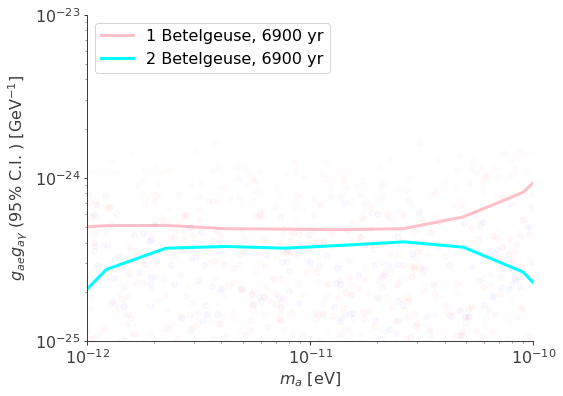

In [113]:
# plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')

plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
plt.plot(ma_bin_cen,smooth(gage_ul,1,mode='nearest'),color='pink',linewidth=3,label='1 Betelgeuse, 6900 yr')


plt.loglog(samples_combined[:,2]*1e-11,samples_combined[:,0]*samples_combined[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='blue')

plt.plot(ma_bin_cen,smooth(gage_ul_combined,1,mode='nearest'),color='cyan',linewidth=3,label='2 Betelgeuse, 6900 yr')


#plt.ylim(1e-25,1e-22)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

plt.xlim(1e-12,1e-10)
plt.ylim(1e-25,1e-23)

plt.legend()

In [117]:
# region in the middle is useful here for comparison, not the boundaries

In [115]:
smooth(gage_ul_combined,1,mode='nearest')/smooth(gage_ul,1,mode='nearest')

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.98860310e-05,
       3.37613952e-03, 4.49509476e-02, 2.40192433e-01, 5.39239978e-01,
       7.24144975e-01, 7.77640437e-01, 7.64329317e-01, 8.02663266e-01,
       8.29388120e-01, 6.51195946e-01, 3.25029329e-01, 6.08606675e-02,
       3.33902260e-03, 7.64491109e-05, 7.93632525e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [118]:
# looks like the expected improvement of 1/sqrt(2)

In [119]:
t_cc[4]

6900.0

In [120]:
# full range with 2 stars (Betelgeuse):
# ...

# PSD

In [144]:
spec_path = 'fit_Betelgeuse_PSD_it01_complete_05_revs/'

In [145]:
fgBet = OGIPLike(name='fgBet',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

14:57:24 WARNING   Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.                  ]8;id=788192;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=247534;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#274\274]8;;\

         WARNING   FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.    ]8;id=309115;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=494246;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#423\423]8;;\

         WARNING   The response is in an extension called MATRIX, which usually means you also need ]8;id=392937;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=525253;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py#459\459]8;;\
                  an ancillary file (ARF) which you didn't provide. You should refer to the                        
                  documentation  of the instrument and make sure you don't need an ARF.                            

         INFO      Auto-probed noise models:                                                    ]8;id=73926;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=383115;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: gaussian                                                      ]8;id=706144;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=211965;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=146489;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=23578;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

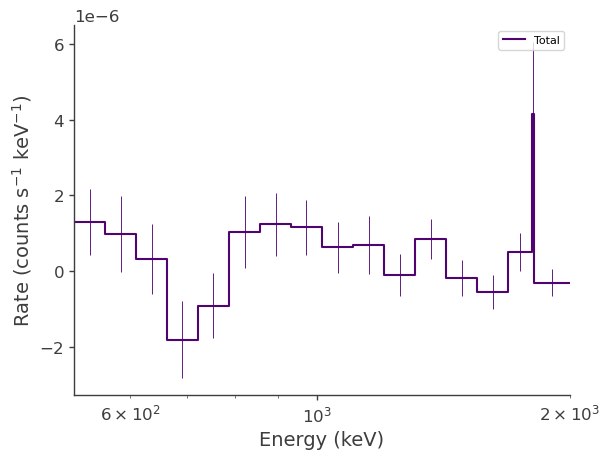

In [222]:
fgBet.view_count_spectrum()
plt.xscale('log')
plt.yscale('linear')
# plt.axvline(1800)

In [147]:
dee = fgBet.energy_boundaries[1]-fgBet.energy_boundaries[0]
ee = 0.5*(fgBet.energy_boundaries[1]+fgBet.energy_boundaries[0])
n_ee = len(ee)

In [151]:
fgBet.set_active_measurements('c0-c17')

14:59:15 INFO      Range c0-c17 translates to channels 0-17                                    ]8;id=340067;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=531936;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

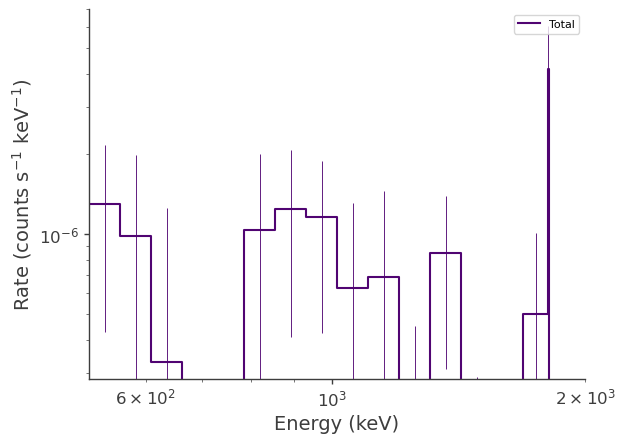

In [152]:
fgBet.view_count_spectrum()
#plt.xscale('linear')
#plt.yscale('linear')
plt.axhline(0)

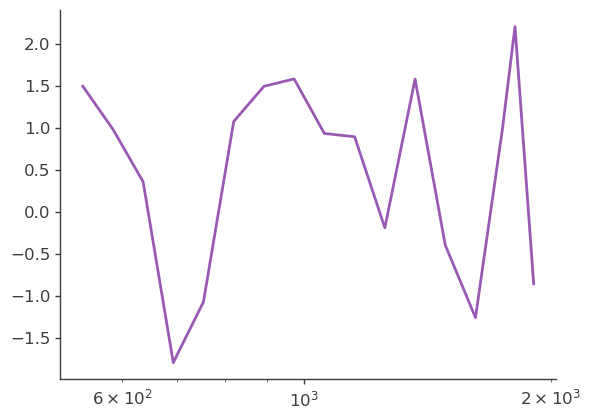

In [153]:
plt.semilogx(ee,fgBet.source_rate/fgBet.source_rate_error)

In [154]:
np.cumsum(fgBet.source_rate*dee),np.sqrt(np.cumsum(fgBet.source_rate_error**2*dee**2))

(array([ 0.00267325,  0.0050797 ,  0.00603949, -0.00017611, -0.0039174 ,
         0.00113438,  0.00820114,  0.01606273,  0.02114484,  0.02772656,
         0.02652355,  0.03794244,  0.03492278,  0.02442029,  0.03131498,
         0.0315815 ,  0.02096026]),
 array([0.00179073, 0.00303807, 0.00406036, 0.00533819, 0.00637743,
        0.0079254 , 0.00923369, 0.01049046, 0.01182675, 0.01394236,
        0.01529765, 0.01692398, 0.01855778, 0.02034711, 0.02151927,
        0.02151961, 0.02483621]))

In [155]:
# 511 keV line
fgBet.source_rate[-2],fgBet.source_rate_error[-2]

(3.3314984e-05, 1.5132547e-05)

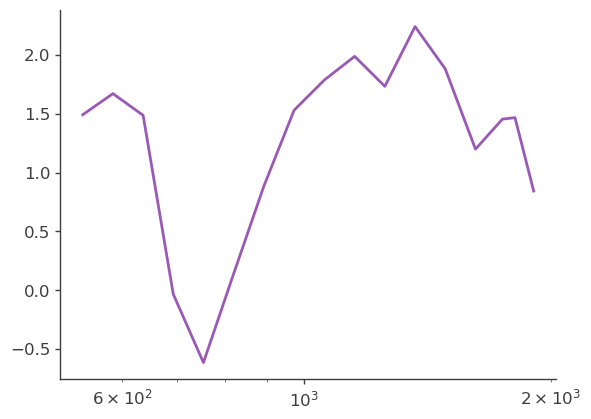

In [156]:
plt.semilogx(ee,np.cumsum(fgBet.source_rate*dee)/np.sqrt(np.cumsum(fgBet.source_rate_error**2*dee**2)))

In [157]:
t_cc

array([1.55e+05, 2.30e+04, 1.30e+04, 1.00e+04, 6.90e+03, 3.70e+03,
       7.30e+02, 4.80e+02, 1.10e+02, 3.40e+01, 7.20e+00, 3.60e+00])

In [158]:
t_idx = 4

fgBet_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_source = PointSource("Betelgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_spectrum)

fgBet_model = Model(fgBet_source)

fgBet_data = DataList(fgBet)

fgBet_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                      value min_value max_value   unit
Betelgeuse...g_agamma   1.0       0.0      None  GeV-1
Betelgeuse...g_ae       3.0       0.0      None       

Fixed parameters (15):
---------------------

                        value min_value max_value unit
Betelgeuse.position.l  199.79       0.0     360.0  deg
Betelgeuse.position.b   -8.96     -90.0      90.0  deg
Betelgeuse...C_B        0.136       0.0     100.0     
Betelgeuse...E0_B       85.15       1.0    1000.0  keV
Betelgeuse...beta_B      1.06       0.0      10.0     
Betelgeuse...C_C        31.81       0.0    1000.0     
Betelgeuse...E0_C       186.4       1.0    1000.0  keV
Betelgeuse...beta_C      3.09       0.0      10.0     
Betelgeuse...C_P          6.5       0.0     100.0     
Betelgeuse...E0_P       120.0       1.0    1000.0  keV
Betelgeuse...beta_P       2.0       0.0      10.0     
Betelgeuse...BT           1.4       0.1      10.0   uG
Betelgeuse...distance   200.0       1.0    1000.0   pc
Betelgeuse...ne         0.013     0.001       1.0     
Betelgeuse...ma           1.0      None      None   eV

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [159]:
g_ae

array([0.25, 0.5 , 0.75, 1.  , 1.5 , 2.  , 2.5 , 3.  ])

In [160]:
fgBet_jl = JointLikelihood(fgBet_model, fgBet_data)

best_fit_parameters_fgBet, likelihood_values_fgBet = fgBet_jl.fit()

15:00:11 INFO      set the minimizer to minuit                                             ]8;id=321338;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=249632;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

15:00:12 WARNING   49.6 percent of samples have been thrown away because they failed the   ]8;id=590691;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=838758;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

result     unit
parameter                                  
Betelgeuse...g_agamma  6.5 +/- 1.0  1 / GeV
Betelgeuse...g_ae      0.0 +/- 3.4

Correlation matrix:

1.00 -0.21
-0.21  1.00

Values of -log(likelihood) at the minimum:

-log(likelihood)
fgBet         11.590742
total         11.590742

Values of statistical measures:

statistical measures
AIC             28.038626
BIC             28.847910

In [161]:
"""fgBet_jl.restore_best_fit()
wa = display_spectrum_model_counts(fgBet_jl,step=True,)
wa.axes[0].set_xscale('linear')
wa.axes[0].set_yscale('log')"""

"fgBet_jl.restore_best_fit()\nwa = display_spectrum_model_counts(fgBet_jl,step=True,)\nwa.axes[0].set_xscale('linear')\nwa.axes[0].set_yscale('log')"

In [162]:
# need overlapping sampling regions as otherwise fit gets stuck in some region
ma_lo = np.array([1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9])*1e11
ma_hi = np.array([1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7])*1e11

In [163]:
samples_tot = []
for i in range(len(ma_lo)):
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = ma_lo[i]*10
    # these bounds are important!!!
    # otherwise, the fit goes haywire and doesnt produce the same as with emceee
    # since the parameters are entirely degenerate, we need to constrain them physically
    # I use a range a bit extended from the Xiao paper
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
    fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=ma_lo[i],upper_bound=ma_hi[i])
    fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
#     fgBet_bs.set_sampler('emcee')
#     fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=2000, n_walkers=8)
    fgBet_bs.set_sampler('multinest')
    fgBet_bs.sampler.setup(n_live_points=1000)
    result = fgBet_bs.sample()
    samples_tot.append(fgBet_bs.raw_samples)

15:00:22 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=78206;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=951845;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

15:00:22 INFO      sampler set to multinest                                                ]8;id=432256;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=163943;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
 ln(ev)=  -13.385273070631323      +/-   2.7445116703032509E-002
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:         5226
 Sampling finished. Exiting MultiNest


15:00:27 INFO      fit restored to maximum of posterior                                         ]8;id=453404;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=976611;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=82564;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=422359;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                                      0.020 +0.006 +4   
Betelgeuse...g_ae                                       (0.0 +8 +1.7) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.15 +0.06 +5) x 10^-3   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet         8.440032
total         8.440032

Values of statistical measures:

statistical measures
AIC                -9.033911
BIC                -8.380424
DIC             -1225.755499
PDIC            -1230.769716
log(Z)             -5.813150

15:00:27 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=581118;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=952922;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=573101;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=249420;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
 ln(ev)=  -13.428330438534571      +/-   2.7821727107280106E-002
 Total Likelihood Evaluations:         5403
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


15:00:33 INFO      fit restored to maximum of posterior                                         ]8;id=302971;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=830052;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=636216;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=567340;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                                      0.011 +0.015 +4   
Betelgeuse...g_ae                                       (0.0 +8 +1.8) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.11 +0.11 +5) x 10^-2   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet         6.926914
total         6.926914

Values of statistical measures:

statistical measures
AIC                -6.007674
BIC                -5.354188
DIC              -754.246461
PDIC             -763.963522
log(Z)             -5.831850

15:00:33 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=439218;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=342791;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=126403;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=614636;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -13.473063850623229      +/-   2.8390433017491962E-002
 Total Likelihood Evaluations:         5355
 Sampling finished. Exiting MultiNest



15:00:39 INFO      fit restored to maximum of posterior                                         ]8;id=969635;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=538349;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=206781;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=521224;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                    
Betelgeuse...g_agamma                                      0.010 +0.017 +4   
Betelgeuse...g_ae                                       (0.0 +7 +1.4) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.15 +0.07 +5) x 10^-1   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet         4.889198
total         4.889198

Values of statistical measures:

statistical measures
AIC                -1.932242
BIC                -1.278755
DIC              -677.319760
PDIC             -691.051128
log(Z)             -5.851277

15:00:39 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=425790;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=420353;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=777043;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=853242;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -13.429883690585692      +/-   2.7794085622718949E-002
 Total Likelihood Evaluations:         5306
 Sampling finished. Exiting MultiNest



15:00:45 INFO      fit restored to maximum of posterior                                         ]8;id=120061;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=28273;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=510947;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=655681;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result     unit
parameter                                                                     
Betelgeuse...g_agamma                               0.010 +0.017 +3.2  1 / GeV
Betelgeuse...g_ae                                  (0.0 +7 +1.7) x 10         
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       0.12 +0.09 +5       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet          2.45171
total          2.45171

Values of statistical measures:

statistical measures
AIC                 2.942733
BIC                 3.596219
DIC              -590.583412
PDIC             -609.016231
log(Z)             -5.832524

15:00:45 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=101532;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=128469;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=573209;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=473645;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -13.422579862655288      +/-   2.7015827526329056E-002
 Total Likelihood Evaluations:         5504
 Sampling finished. Exiting MultiNest



15:00:51 INFO      fit restored to maximum of posterior                                         ]8;id=451402;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=215143;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=518643;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=817335;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                   
Betelgeuse...g_agamma                                   0.0237 +0.0033 +4   
Betelgeuse...g_ae                                      (0.0 +6 +1.9) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma  (0.216 -0.010 +5) x 10   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet          -1.1828
total          -1.1828

Values of statistical measures:

statistical measures
AIC                10.211754
BIC                10.865240
DIC            -29429.628428
PDIC           -29453.178080
log(Z)             -5.829352

15:00:51 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=943444;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=969917;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=866498;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=49526;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -13.175289140416531      +/-   2.0294976130699388E-002
 Total Likelihood Evaluations:         5105
 Sampling finished. Exiting MultiNest



15:00:57 INFO      fit restored to maximum of posterior                                         ]8;id=971616;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=700669;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=674490;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=43384;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                       
Betelgeuse...g_agamma                              (0.0013 +0.0023 +1.1) x 10   
Betelgeuse...g_ae                                  (0.00002 +0.00013 +8) x 10   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma      (0.29 -0.04 +5) x 10^2   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet        -3.256117
total        -3.256117

Values of statistical measures:

statistical measures
AIC                14.358388
BIC                15.011874
DIC                -3.724216
PDIC              -35.866268
log(Z)             -5.721955

15:00:57 WARNING   External parameter cons_fgBet already exist in the model. Overwriting it...         ]8;id=616835;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py\model.py]8;;\:]8;id=573036;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/astromodels/core/model.py#590\590]8;;\

         INFO      sampler set to multinest                                                ]8;id=105484;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=942455;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
  analysing data from chains/fit-.txt ln(ev)=  -13.028393345640847      +/-   1.0650622440253997E-002
 Total Likelihood Evaluations:         4599
 Sampling finished. Exiting MultiNest



15:01:02 INFO      fit restored to maximum of posterior                                         ]8;id=437429;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=375516;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=485499;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=497328;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result  \
parameter                                                                       
Betelgeuse...g_agamma                              (0.0011 +0.0034 +2.3) x 10   
Betelgeuse...g_ae                                        (0.2 +1.2 +4) x 10^2   
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma      (0.11 +0.11 +5) x 10^3   

                                                      unit  
parameter                                                   
Betelgeuse...g_agamma                              1 / GeV  
Betelgeuse...g_ae                                           
Betelgeuse.spectrum.main.ALPProductionSpectrum.ma       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet        -4.404112
total        -4.404112

Values of statistical measures:

statistical measures
AIC                16.654377
BIC                17.307863
DIC                19.964411
PDIC              -19.238517
log(Z)             -5.658159

In [164]:
n_samples = [np.array(samples_tot).ravel()[i].shape[0] for i in range(7)]
n_samples_sum = np.sum(n_samples)
n_samples_cumsum = np.cumsum(n_samples)
n_samples_sum

19995

In [165]:
n_samples_cumsum = np.concatenate([np.array([0]),n_samples_cumsum])
n_samples_cumsum

array([    0,  2931,  5831,  8700, 11573, 14545, 17372, 19995])

In [166]:
np.array(samples_tot)[0].shape

(2931, 3)

In [167]:
samples_tot[0].shape

(2931, 3)

In [168]:
n_samples_cumsum[0],n_samples_cumsum[0+1]

(0, 2931)

In [169]:
what = np.zeros((n_samples_sum,3))
for i in range(7):
    what[n_samples_cumsum[i]:n_samples_cumsum[i+1],:] = samples_tot[i]

In [170]:
what.shape

(19995, 3)

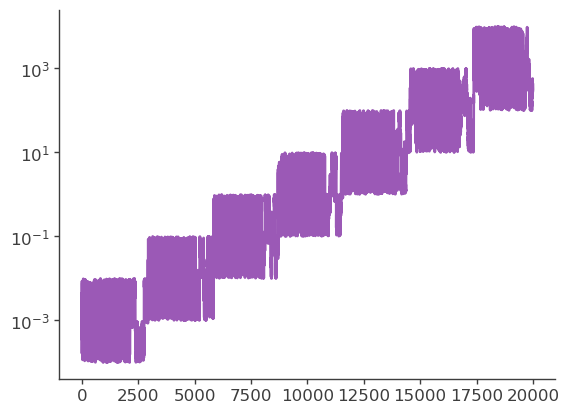

In [171]:
plt.plot(what[:,2])
plt.yscale('log')

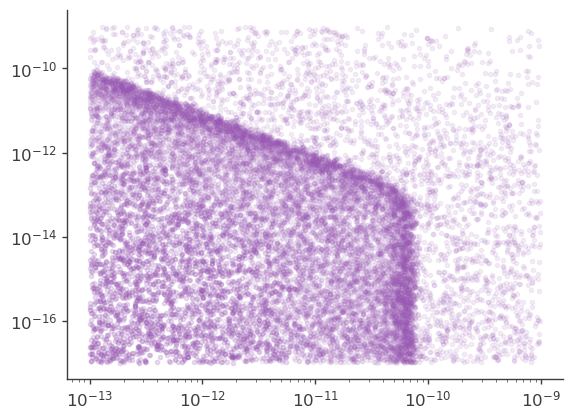

In [172]:
plt.plot(what[:,0]*1e-11,what[:,1]*1e-13,'.',alpha=0.1)
plt.yscale('log')
plt.xscale('log')

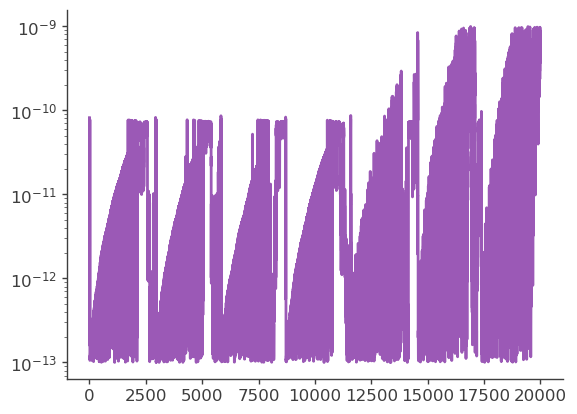

In [173]:
plt.plot(what[:,0]*1e-11)
plt.yscale('log')

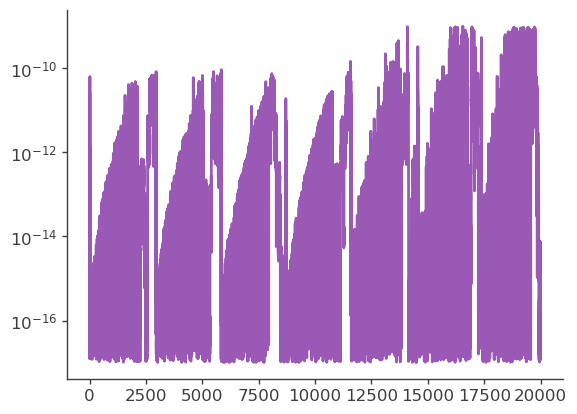

In [174]:
plt.plot(what[:,1]*1e-13)
plt.yscale('log')

In [175]:
"""# lowest masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 0.01
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-3,upper_bound=1e-1)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples_lo_lo = fgBet_bs.raw_samples

# medium masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 1
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples_lo = fgBet_bs.raw_samples

# higher masses:
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 100
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)
fgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e1,upper_bound=1e3)
fgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)
fgBet_bs.set_sampler('emcee')
fgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)
result = fgBet_bs.sample()
samples = fgBet_bs.raw_samples"""

"# lowest masses:\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 0.01\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-10,upper_bound=1e10)\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.prior = Log_uniform_prior(lower_bound=1e-3,upper_bound=1e-1)\nfgBet_bs = BayesianAnalysis(fgBet_model, fgBet_data)\nfgBet_bs.set_sampler('emcee')\nfgBet_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=10)\nresult = fgBet_bs.sample()\nsamples_lo_lo = fgBet_bs.raw_samples\n\n# medium masses:\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma.free = True\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.ma = 1\nfgBet_model.Betelgeuse.spectrum.main.ALPProductionSpectrum.g_ae.prior

In [176]:
"""plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)
plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)
plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)

plt.ylim(1e-25,1e-20)"""

"plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\nplt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\nplt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)\n\nplt.ylim(1e-25,1e-20)"

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$  [GeV$^{-1}$]')

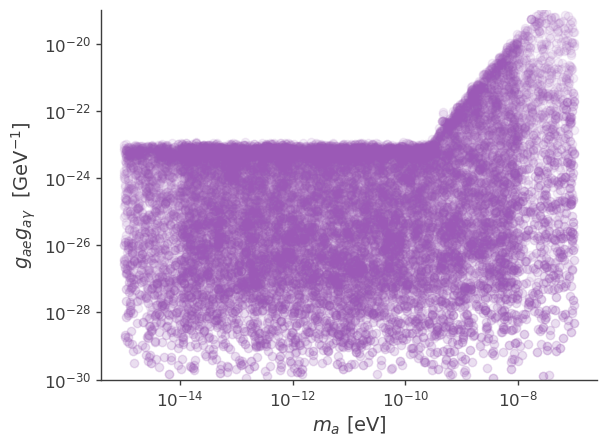

In [177]:
plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='o',linestyle='',alpha=0.1)

plt.ylim(1e-30,1e-19)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$  [GeV$^{-1}$]')

In [178]:
n_ma_bins = 30
ma_bin_edges = np.geomspace(1e-15,1e-7,n_ma_bins+1)
ma_bin_min = ma_bin_edges[0:-1]
ma_bin_max = ma_bin_edges[1:]
ma_bin_cen = 0.5*(ma_bin_max+ma_bin_min)

In [179]:
gage_ul = np.zeros(n_ma_bins)
for i in range(n_ma_bins):
    try:
        idx = np.where((what[:,2]*1e-11 >= ma_bin_min[i]) & (what[:,2]*1e-11 <= ma_bin_max[i]))[0]
        #print(idx)
        gage_tmp = np.percentile(what[idx,0]*what[idx,1],95)
        gage_ul[i] = gage_tmp*1e-24
    except:
        print('{0} not working'.format(i))

In [180]:
from scipy.ndimage import gaussian_filter1d as smooth

In [181]:
# showing everything for own checks

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

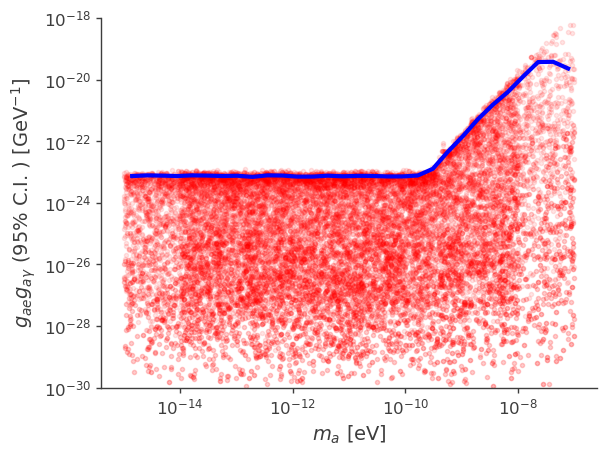

In [182]:
# plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')


plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='.',linestyle='',alpha=0.1,color='red')

plt.plot(ma_bin_cen,smooth(gage_ul,0.5,mode='nearest'),color='blue',linewidth=3)


plt.ylim(1e-30,1e-18)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

In [183]:
# what we would show in a paper:

Text(0, 0.5, '$g_{ae}g_{a\\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

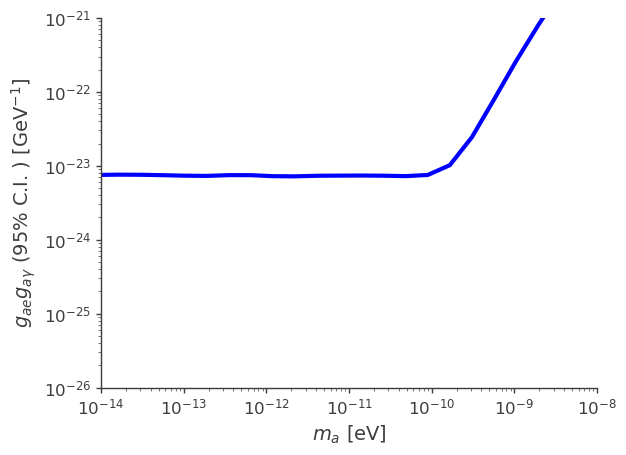

In [184]:
#plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='.',linestyle='',alpha=0.1,color='red')

plt.loglog(ma_bin_cen,smooth(gage_ul,1,mode='nearest'),color='blue',linewidth=3)


plt.ylim(1e-26,1e-21)
plt.xlim(1e-14,1e-8)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

In [185]:
# neat

In [186]:
# now can repeat for other times until explosion ...
# more samples
# whatever

In [187]:
idx = np.where((what[:,2]*1e-11 >= 0.99e-11) & (what[:,2]*1e-11 <= 1.01e-11))[0]
        #print(idx)
idx2 = np.where((what[:,2]*1e-11 >= 0.99e-10) & (what[:,2]*1e-11 <= 1.01e-10))[0]
        #print(idx)
idx3 = np.where((what[:,2]*1e-11 >= 0.99e-9) & (what[:,2]*1e-11 <= 1.01e-9))[0]
        #print(idx)
idx4 = np.where((what[:,2]*1e-11 >= 0.99e-12) & (what[:,2]*1e-11 <= 1.01e-12))[0]
        #print(idx)
idx5 = np.where((what[:,2]*1e-11 >= 0.99e-13) & (what[:,2]*1e-11 <= 1.01e-13))[0]
        #print(idx)

In [188]:
idx35 = np.where(what[:,2]*1e-11 < 3.5e-11)[0]

In [189]:
idx.shape,idx2.shape,idx3.shape,idx4.shape,idx5.shape

((16,), (17,), (25,), (27,), (18,))

In [190]:
# what[idx,0]*1e-11

Text(0, 0.5, '$g_{ae}$')

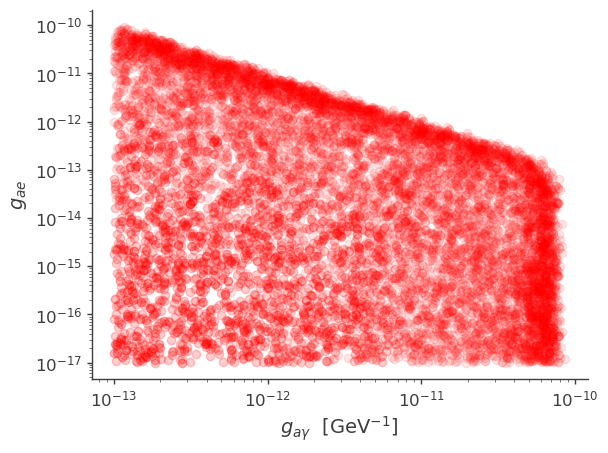

In [191]:
plt.loglog(what[idx35,0]*1e-11,what[idx35,1]*1e-13,'ro',alpha=0.1)
# plt.loglog(what[idx2,0]*1e-11,what[idx2,1]*1e-13,'bo',alpha=0.1)
# plt.loglog(what[idx3,0]*1e-11,what[idx3,1]*1e-13,'go',alpha=0.1)
# plt.loglog(what[idx4,0]*1e-11,what[idx4,1]*1e-13,'ko',alpha=0.1)
# plt.loglog(what[idx5,0]*1e-11,what[idx5,1]*1e-13,'mo',alpha=0.1)
plt.xlabel(r'$g_{a\gamma}$  [GeV$^{-1}$]')
plt.ylabel(r'$g_{ae}$')

In [192]:
n_gagamma_bins = 30
gagamma_bin_edges = np.geomspace(1e-13,1e-10,n_gagamma_bins+1)
gagamma_bin_min = gagamma_bin_edges[0:-1]
gagamma_bin_gagammax = gagamma_bin_edges[1:]
gagamma_bin_cen = 0.5*(gagamma_bin_gagammax+gagamma_bin_min)

In [193]:
gae_ul = np.zeros(n_gagamma_bins)
for i in range(n_gagamma_bins):
    try:
        idx = np.where((what[:,0]*1e-11 >= gagamma_bin_min[i]) & (what[:,0]*1e-11 <= gagamma_bin_gagammax[i]) & (what[:,2]*1e-11 < 3.5e-11))[0]
        #print(idx)
        gae_tmp = np.percentile(what[idx,1],95)
        gae_ul[i] = gae_tmp*1e-13
    except:
        print('{0} not working'.format(i))

Text(0, 0.5, '$g_{ae}$')

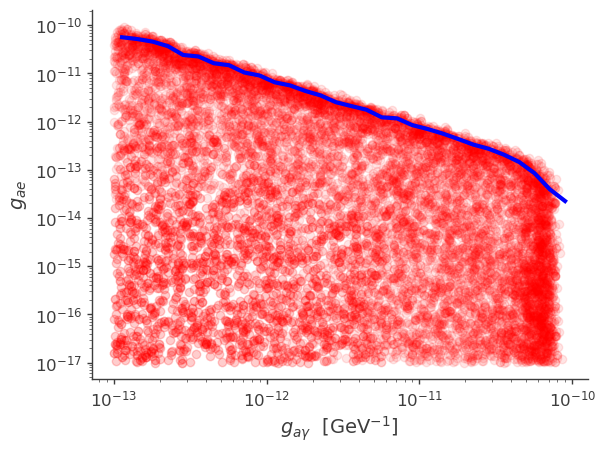

In [194]:
plt.loglog(what[idx35,0]*1e-11,what[idx35,1]*1e-13,'ro',alpha=0.1)
plt.plot(gagamma_bin_cen,smooth(gae_ul,0.05,mode='nearest'),color='blue',linewidth=3)
plt.xlabel(r'$g_{a\gamma}$  [GeV$^{-1}$]')
plt.ylabel(r'$g_{ae}$')

In [195]:
spec_path = 'fit_Betelgeuse_PSD_it01_complete_05_revs/'

In [196]:
fgBet_1 = OGIPLike(name='fgBet_1',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

15:02:45 WARNING   Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.                  ]8;id=738410;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=980339;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#274\274]8;;\

         WARNING   FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.    ]8;id=441191;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=940929;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#423\423]8;;\

         WARNING   The response is in an extension called MATRIX, which usually means you also need ]8;id=317394;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=288528;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py#459\459]8;;\
                  an ancillary file (ARF) which you didn't provide. You should refer to the                        
                  documentation  of the instrument and make sure you don't need an ARF.                            

         INFO      Auto-probed noise models:                                                    ]8;id=578038;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=537211;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: gaussian                                                      ]8;id=758754;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=461924;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=992232;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=598676;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

In [197]:
fgBet_2 = OGIPLike(name='fgBet_2',
                 observation=spec_path+'spectra_Betelgeuse_updated.fits',
                 response=spec_path+'spectral_response.rmf.fits')

15:02:52 WARNING   Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.                  ]8;id=141484;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=583559;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#274\274]8;;\

         WARNING   FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.    ]8;id=376333;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py\pha_spectrum.py]8;;\:]8;id=214592;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/spectrum/pha_spectrum.py#423\423]8;;\

         WARNING   The response is in an extension called MATRIX, which usually means you also need ]8;id=718596;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py\response.py]8;;\:]8;id=82652;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/utils/OGIP/response.py#459\459]8;;\
                  an ancillary file (ARF) which you didn't provide. You should refer to the                        
                  documentation  of the instrument and make sure you don't need an ARF.                            

         INFO      Auto-probed noise models:                                                    ]8;id=936241;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=657538;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: gaussian                                                      ]8;id=310784;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=302234;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: None                                                           ]8;id=104236;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=720155;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/plugins/SpectrumLike.py#471\471]8;;\

In [198]:
t_idx = 4

fgBet_2_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_2_spectrum.ma.free = True
fgBet_2_spectrum.ma = 1

fgBet_2_spectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
fgBet_2_spectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
fgBet_2_spectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)

fgBet_2_source = PointSource("Bet_2elgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_2_spectrum)

# fgBet_2_model = Model(fgBet_2_source)

# fgBet_2_data = DataList(fgBet_2)

# fgBet_2_model.display(complete=True)

In [199]:
t_idx = 4

fgBet_1_spectrum = ALPProductionSpectrum(g_agamma=1.0, g_ae=g_ae[-1], C_B=C_B[t_idx], E0_B=E0_B[t_idx], beta_B=beta_B[t_idx],
                                 C_P=C_P[t_idx], E0_P=E0_P[t_idx], beta_P=beta_P[t_idx],
                                 C_C=C_C[t_idx], 
                                 E0_C=E0_C[t_idx], 
                                 beta_C=beta_C[t_idx])

fgBet_1_spectrum.ma.free = True
fgBet_1_spectrum.ma = 1

fgBet_1_spectrum.g_ae.prior = Log_uniform_prior(lower_bound=1e-4,upper_bound=1e4)
fgBet_1_spectrum.g_agamma.prior = Log_uniform_prior(lower_bound=1e-2,upper_bound=1e2)
fgBet_1_spectrum.ma.prior = Log_uniform_prior(lower_bound=1e-1,upper_bound=1e1)

fgBet_1_source = PointSource("Bet_1elgeuse", l=199.79, b=-8.96, spectral_shape=fgBet_1_spectrum)

# fgBet_1_model = Model(fgBet_1_source)

# fgBet_1_data = DataList(fgBet_1)

# fgBet_1_model.display(complete=True)

In [200]:
model_combined = Model(fgBet_1_source,fgBet_2_source)

In [201]:
model_combined.display(complete=True)

Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                        value min_value max_value   unit
Bet_1elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_1elgeuse...g_ae       3.0       0.0      None       
Bet_1elgeuse...ma         1.0      None      None     eV
Bet_2elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_2elgeuse...g_ae       3.0       0.0      None       
Bet_2elgeuse...ma         1.0      None      None     eV

Fixed parameters (28):
---------------------

                          value min_value max_value unit
Bet_1elgeuse.position.l  199.79       0.0     360.0  deg
Bet_1elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_1elgeuse...C_B        0.136       0.0     100.0     
Bet_1elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_1elgeuse...beta_B      1.06       0.0      10.0     
Bet_1elgeuse...C_C        31.81       0.0    1000.0     
Bet_1elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_1elgeuse...beta_C      3.09       0.0      10.0     
Bet_1elgeuse...C_P          6.5       0.0     100.0     
Bet_1elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_1elgeuse...beta_P       2.0       0.0      10.0     
Bet_1elgeuse...BT           1.4       0.1      10.0   uG
Bet_1elgeuse...distance   200.0       1.0    1000.0   pc
Bet_1elgeuse...ne         0.013     0.001       1.0     
Bet_2elgeuse.position.l  199.79       0.0     360.0  deg
Bet_2elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_2elgeuse...C_B        0.136       0.0     100.0     
Bet_2elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_2elgeuse...beta_B      1.06       0.0      10.0     
Bet_2elgeuse...C_C        31.81       0.0    1000.0     
Bet_2elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_2elgeuse...beta_C      3.09       0.0      10.0     
Bet_2elgeuse...C_P          6.5       0.0     100.0     
Bet_2elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_2elgeuse...beta_P       2.0       0.0      10.0     
Bet_2elgeuse...BT           1.4       0.1      10.0   uG
Bet_2elgeuse...distance   200.0       1.0    1000.0   pc
Bet_2elgeuse...ne         0.013     0.001       1.0     

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [202]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.ma,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.ma
)

In [203]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_ae,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.g_ae
)

In [204]:
model_combined.link(
    model_combined.Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma,
    model_combined.Bet_2elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma
)

In [205]:
model_combined.display(complete=True)

Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                        value min_value max_value   unit
Bet_2elgeuse...g_agamma   1.0       0.0      None  GeV-1
Bet_2elgeuse...g_ae       3.0       0.0      None       
Bet_2elgeuse...ma         1.0      None      None     eV

Fixed parameters (34):
---------------------

                          value min_value max_value unit
Bet_1elgeuse.position.l  199.79       0.0     360.0  deg
Bet_1elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_1elgeuse...a            0.0      None      None   eV
Bet_1elgeuse...b            1.0      None      None     
Bet_1elgeuse...C_B        0.136       0.0     100.0     
Bet_1elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_1elgeuse...beta_B      1.06       0.0      10.0     
Bet_1elgeuse...C_C        31.81       0.0    1000.0     
Bet_1elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_1elgeuse...beta_C      3.09       0.0      10.0     
Bet_1elgeuse...C_P          6.5       0.0     100.0     
Bet_1elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_1elgeuse...beta_P       2.0       0.0      10.0     
Bet_1elgeuse...BT           1.4       0.1      10.0   uG
Bet_1elgeuse...distance   200.0       1.0    1000.0   pc
Bet_1elgeuse...ne         0.013     0.001       1.0     
Bet_2elgeuse.position.l  199.79       0.0     360.0  deg
Bet_2elgeuse.position.b   -8.96     -90.0      90.0  deg
Bet_2elgeuse...C_B        0.136       0.0     100.0     
Bet_2elgeuse...E0_B       85.15       1.0    1000.0  keV
Bet_2elgeuse...beta_B      1.06       0.0      10.0     
Bet_2elgeuse...C_C        31.81       0.0    1000.0     
Bet_2elgeuse...E0_C       186.4       1.0    1000.0  keV
Bet_2elgeuse...beta_C      3.09       0.0      10.0     
Bet_2elgeuse...C_P          6.5       0.0     100.0     
Bet_2elgeuse...E0_P       120.0       1.0    1000.0  keV
Bet_2elgeuse...beta_P       2.0       0.0      10.0     
Bet_2elgeuse...BT           1.4       0.1      10.0   uG
Bet_2elgeuse...distance   200.0       1.0    1000.0   pc
Bet_2elgeuse...ne         0.013     0.001       1.0     

Properties (0):
--------------------

(none)


Linked parameters (3):
----------------------

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_agamma
current value                                                1.0       
function                                                    Line       
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr...       
unit                                                     1 / GeV       

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.g_ae
current value                                                3.0   
function                                                    Line   
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr...   
unit                                                               

              Bet_1elgeuse.spectrum.main.ALPProductionSpectrum.ma
current value                                                1.0 
function                                                    Line 
linked to      Bet_2elgeuse.spectrum.main.ALPProductionSpectr... 
unit                                                          eV 


Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [206]:
fgBet_1.assign_to_source("Bet_1elgeuse")

In [207]:
fgBet_2.assign_to_source("Bet_2elgeuse")

In [208]:
data_combined = DataList(fgBet_1,fgBet_2)

In [209]:
fgBet_combined_bs = BayesianAnalysis(model_combined, data_combined)

In [210]:
import warnings
warnings.simplefilter("ignore")

In [211]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [212]:
silence_warnings()

In [213]:
# fgBet_combined_bs.set_sampler('emcee')
# fgBet_combined_bs.sampler.setup(n_iterations=1000, n_burn_in=500, n_walkers=8)
fgBet_combined_bs.set_sampler('multinest')
fgBet_combined_bs.sampler.setup(n_live_points=1000)
result = fgBet_combined_bs.sample()
samples_combined = fgBet_combined_bs.raw_samples

15:03:19 INFO      sampler set to multinest                                                ]8;id=984869;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=47471;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************
 ln(ev)=  -25.891732664948673      +/-   3.5218826662995806E-002
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:         6754
 Sampling finished. Exiting MultiNest


15:03:34 INFO      fit restored to maximum of posterior                                         ]8;id=615908;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=125009;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=413089;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=149857;file:///Users/saurabh/miniconda3/envs/threeML/lib/python3.9/site-packages/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result     unit
parameter                                                   
Bet_2elgeuse...g_agamma             0.015 +0.020 +6  1 / GeV
Bet_2elgeuse...g_ae      (0.00001 +0.00015 +4) x 10         
Bet_2elgeuse...ma                     0.10 +0.11 +5       eV

Values of -log(posterior) at the minimum:

-log(posterior)
fgBet_1         2.590413
fgBet_2         2.590413
total           5.180825

Values of statistical measures:

statistical measures
AIC                -3.561651
BIC                 0.217431
DIC            -32278.080465
PDIC           -32323.233823
log(Z)            -11.244637

In [214]:
#tot_samples = np.concatenate([samples,samples_lo,samples_lo_lo])
tot_samples = samples_combined

In [215]:
tot_samples.shape

(3922, 3)

In [216]:
gage_ul_combined = np.zeros(n_ma_bins)
for i in range(n_ma_bins):
    try:
        idx = np.where((tot_samples[:,2]*1e-11 >= ma_bin_min[i]) & (tot_samples[:,2]*1e-11 <= ma_bin_max[i]))[0]
        #print(idx)
        gage_tmp = np.percentile(tot_samples[idx,0]*tot_samples[idx,1],95)
        gage_ul_combined[i] = gage_tmp*1e-24
    except:
        print('{0} is not working'.format(i))

0 is not working
1 is not working
2 is not working
3 is not working
4 is not working
5 is not working
6 is not working
7 is not working
8 is not working
9 is not working
10 is not working
19 is not working
20 is not working
21 is not working
22 is not working
23 is not working
24 is not working
25 is not working
26 is not working
27 is not working
28 is not working
29 is not working


In [217]:
from scipy.ndimage import gaussian_filter1d as smooth

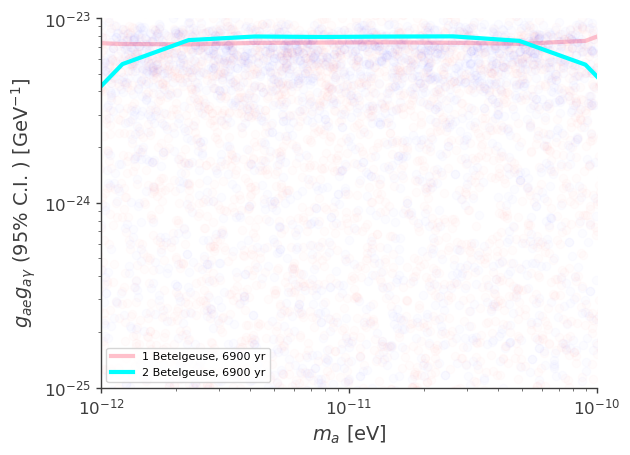

In [218]:
# plt.loglog(samples[:,2]*1e-11,samples[:,0]*samples[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo[:,2]*1e-11,samples_lo[:,0]*samples_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
# plt.loglog(samples_lo_lo[:,2]*1e-11,samples_lo_lo[:,0]*samples_lo_lo[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')

plt.loglog(what[:,2]*1e-11,what[:,0]*what[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='red')
plt.plot(ma_bin_cen,smooth(gage_ul,1,mode='nearest'),color='pink',linewidth=3,label='1 Betelgeuse, 6900 yr')


plt.loglog(samples_combined[:,2]*1e-11,samples_combined[:,0]*samples_combined[:,1]*1e-24,marker='o',linestyle='',alpha=0.01,color='blue')

plt.plot(ma_bin_cen,smooth(gage_ul_combined,1,mode='nearest'),color='cyan',linewidth=3,label='2 Betelgeuse, 6900 yr')


#plt.ylim(1e-25,1e-22)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{ae}g_{a\gamma}$ (95% C.I. ) [GeV$^{-1}$]')

plt.xlim(1e-12,1e-10)
plt.ylim(1e-25,1e-23)

plt.legend()

In [219]:
# region in the middle is useful here for comparison, not the boundaries

In [220]:
smooth(gage_ul_combined,1,mode='nearest')/smooth(gage_ul,1,mode='nearest')

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.44866256e-04,
       4.97586389e-03, 6.24353076e-02, 3.22235533e-01, 7.78708792e-01,
       1.05401328e+00, 1.08287347e+00, 1.07194885e+00, 1.07453590e+00,
       1.08327156e+00, 1.03755450e+00, 7.43745627e-01, 2.36017383e-01,
       1.92685128e-02, 4.66951028e-04, 4.14479181e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])